In [2]:
import os
import csv, pickle, json
import re
UniProt_RE = re.compile("[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2}")

from collections import *
from itertools import *
from bisect import bisect

import numpy as np
from scipy.stats import ttest_ind, wilcoxon, ttest_rel, mannwhitneyu
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import statsmodels.stats.multitest as smm

from Bio import SeqIO
from Bio.PDB import *

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, to_rgb, to_rgba, rgb2hex, Normalize, rgb_to_hsv, hsv_to_rgb
from matplotlib.colorbar import ColorbarBase
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("white")

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Calibri"
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.3
plt.rcParams['lines.linewidth'] = 2.5

plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['svg.fonttype'] = 'none'


blue = "#007EEA"
orange = "#FEB80A"
green = "#7FD13B"
pink = "#EA157A"
white = "#FFFFFF"
purple = "#754AB2"
darkgreen = "#00A053"

warm_pink = LinearSegmentedColormap.from_list("warm_pink", colors=[pink, 'w'])

from ipywidgets import IntProgress, interact, IntSlider
from IPython.display import display

# Data Loading:

Load in data as a dictionary mapping domain keys to weights. Also, must load in domain alignmnets in PFAM format. 

In [3]:
npzs = [f for f in os.listdir("data/weights") if f.endswith('.npz')]
hsmd_weights = {npz.split('.')[0]: np.load(os.path.join("data/weights",npz))['interaction_weights'] for npz in npzs}
basis = np.load(os.path.join("data/weights",npzs[0]))['basis_weights']

In [4]:
aa_ordering = tuple(["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y", "y"])
aa_idxing = {aa:idx for idx, aa in enumerate(aa_ordering)}
alignments = dict()
for f in os.listdir("data/alignment/"):
    domain = f.split(".")[0]
    alignments[domain] = [(s.id.split("|")[-2], str(s.seq)) for s in SeqIO.parse("data/alignment/"+f, 'stockholm')]

In [5]:
maq_coolwarm = LinearSegmentedColormap.from_list('maq_coolwarm', [blue, 'white', pink])
aa_pY = aa_ordering[:-1] + ('pY', )

aa_reordering = ["A", "V", "I", "L", "M", "F", "Y", "W","C", "G", "P", "S", "T", "N", "Q", "R", "H", "K", "D", "E", "pY"]
_r = [aa_idxing[aa] if aa != 'pY' else aa_idxing['y'] for aa in aa_reordering]    

In [6]:
# Dictionary of model shapes for ease of remodeling. 
domain_lengths, peptide_lengths = dict(), dict()
for dtype, weight in hsmd_weights.items():
    dlen = len(alignments[dtype][0][1])
    plen = int(weight.shape[0]/dlen)
    
    domain_lengths[dtype] = dlen
    peptide_lengths[dtype] = plen

# Energy Mapping Code

Used below. Code is a bit more involved, so the underlying code is separated out. 

The most instructive place to start is likely in two cells below in the map_to_colorscale function. The first cell is primarily used to plot the output functions.

In [7]:
# _permute_matrix and _getsigmat are functions to re-estimate a center for the correlation
# This is likely unnecessary and the center should be set manually. 
def _permute_matrix(mat, rows=False, cols=True):
    """
    Permutes an input matrix with options for permuting on the basis of rows, columns or the entire matrix
    """
    matc = mat.copy()
    if cols:
        for cidx in range(matc.shape[1]):
            matc[:,cidx] = np.random.permutation(matc[:,cidx])
    elif rows:
        for ridx in range(matc.shape[0]):
            matc[ridx] = np.random.permutation(matc[ridx])
    else:
        matc = np.random.permutation(matc.flatten()).reshape(matc.shape)
    return matc

def _getsigmat(dtype, weights, basis, dlength, ordered_corrmat, nperms=10, alpha=.01):
    """
    Computes a quick significance matrix for the correlations on the basis of permutations.   
    """
    mat = np.matmul(weights[dtype], basis).reshape(dlength, -1)

    perm_dist = list()
    for _ in range(nperms):
        permuted = _permute_matrix(mat)
        permuted_corrmat = np.corrcoef(permuted)
        perm_dist.extend(permuted_corrmat[np.triu_indices_from(permuted_corrmat, k=1)])
    
    perm_dist = sorted(perm_dist)
    sigmat = np.empty_like(ordered_corrmat)
    for i,j in combinations(range(ordered_corrmat.shape[0]), r=2):
        idx = bisect(perm_dist, ordered_corrmat[i,j])
        pval = 1 - (idx / len(perm_dist))
        sigmat[i,j] = pval
        sigmat[j,i] = pval
        
    reject, _, _, _ = smm.multipletests(sigmat[np.triu_indices_from(sigmat, k=1)], method='fdr_bh', alpha=alpha)
    sigmat[np.triu_indices_from(sigmat, k=1)] = reject.astype("int")
    sigmat[np.tril_indices_from(sigmat)] = 0
    sigmat += sigmat.T
    
    center = perm_dist[int((1-alpha) * len(perm_dist))]
    return sigmat, center

def _getcorrmat(dtype, weights, basis, dlength, return_dmat=False):
    """
    Computes the correlation matrix and linkage associated with the 
    
    dtype: domain type input -- used to extract weights from input values. 
    weights, basis, dlength: metadata
    return_dmat: boolean whether to return the distance matrix. 
    
    Returns:
        correlation matrix: computed correlation matrix
        reordered correlation matrix: reordered correlation matrix on the basis of dendrogram
        linkage: linkage matrix 
        distance matrix: computes intra-correlation distances
    """
    mat = np.matmul(weights[dtype], basis).reshape(dlength, -1)
    corrmat = np.corrcoef(mat)

    Z = hier.linkage(corrmat, method='average', optimal_ordering=True)
    reordering = hier.leaves_list(Z)
    
    corrmat_reordered = corrmat[reordering][:,reordering]
    
    if return_dmat: 
        return corrmat, corrmat_reordered, reordering, Z, ssd.squareform(ssd.pdist(corrmat))
    return corrmat, corrmat_reordered, reordering, Z

def convert_to_cmap(ordered_colors):
    """
    Helper function for converting a list of colors (ordered_colors) into a matplotlib heatmap. To do so,
    one has to map every color to a single value and then re-index a list. 
    
    ordered_colors: list of input colors
    
    Returns:
        reidxed: list of values
        cmap: colormap
    """
    cmap = sorted(set(ordered_colors))
    color_idxing = {c:idx for idx, c in enumerate(cmap)}
        
    reidxed = [color_idxing[c] for c in ordered_colors]
    
    return reidxed, cmap

maqCoolWarm = LinearSegmentedColormap.from_list("maqCoolWarm", [blue, 'w', pink])
greyRed = LinearSegmentedColormap.from_list('coolwarm', ['#DCDCDC', 'w', "#C41E3A"])
whiteGrey = LinearSegmentedColormap.from_list('whiteGrey', ['w', "w", "k"])
def plot_clustermap(dtype, coloring=None, weights=hsmd_weights, basis=basis, dlengths=domain_lengths, plengths=peptide_lengths, 
                    figsize=(20,20), annot_regions=False, scale=(0,.3, 0.5), cmap=whiteGrey, 
                    lineseps=False, linecolor='#DCDCDC', linewidths=.15, mask_diagonal=True,
                    include_unordered=True, nperms=100, alpha=.001, set_scale=True,
                    include_dendrogram=True, include_dendrogram_ax=False, dendrogram_threshold=None, dendrogram_color_palette=None):
    """
    Plots the underlying clustermap output from map_to_colorscale below. Not directly called in the code.
    
    dtype: domain type input -- used to extract weights from input values. 
    coloring: ordered coloring input from 
    weights, basis, dlengths, plengths: metadata
    figsize, annot_regions, scale, cmap, lineseps, linecolor, linewidths, mask_diagonal: plotting options
    include_unordered: flag defining whether or not to include the unordered data. 
    nperms, alpha, set_scale: quick estimate of updated center. 
        n.b. This is not really doing much other than a quick re-estimate of the center. It probably should be removed. 
    include_dendrogram, include_dendrogram_ax: options controlling whether dendrogram data is used.
    dendrogram_threshold, dendrogram_color_palette: dendrogram data - ignored if include_dendrogram flags are false
    
    Returns:
        figure: matplotlib figure 
        reordering: the reordered indices
        corrmat: the raw correlation matrix. 
    """
    
    vmin, center, vmax = scale
    
    # Creates a matrix with either a split matrix (LL - unordered, UR - reordered) or a complete re-ordered matrix. 
    corrmat, corrmat_reordered, reordering, linkage = _getcorrmat(dtype, weights, basis, dlengths[dtype])
    if include_unordered:
        plotted_matrix = np.empty_like(corrmat)
        plotted_matrix[np.tril_indices_from(plotted_matrix, k=-1)] = corrmat[np.tril_indices_from(corrmat, k=-1)]
        plotted_matrix[np.triu_indices_from(plotted_matrix, k=1)] = corrmat_reordered[np.triu_indices_from(corrmat_reordered, k=1)]
        np.fill_diagonal(plotted_matrix, 1)
    else:
        plotted_matrix = corrmat_reordered
    
    # Optionally estimate a new center on the basis of a quick series of permutations. 
    if set_scale:
        _, center = _getsigmat(dtype, weights, basis, dlengths[dtype], corrmat_reordered, nperms=nperms, alpha=alpha)
    
    # A ridiculously complicated way to define the set of axes used in this function
    # Basically, 
    def deactivate_axes(ax_list, ax_idxes=None):
        for ridx, cidx in ax_idxes: ax_list[ridx,cidx].axis('off')
    def update_dendrogram_figsize(figsize):
        w,h = figsize
        w += 1/5 * h
        return (w,h)

    if coloring is not None and include_dendrogram:
        f, axes = plt.subplots(4,4, figsize=update_dendrogram_figsize(figsize), 
                               gridspec_kw={"width_ratios":[1,50,1,10], "height_ratios":[1,50,1,1], "wspace":0.03, "hspace":0.03})
        
        dendrogram_ax = axes[1,3]
        heatmap_ax = axes[1,1]
        cbar_ax = axes[3,1]
        
        # Coloring axes ordering: [left,top,bottom,right]; 
        coloring_axes = [axes[1,0], axes[0,1], axes[2,1], axes[1,2]]
        deactivate_axes(axes, [(0,0), (2,0), (3,0), (0,2), (2,2), (3,2), (0,3), (2,3), (3,3)])        
    elif coloring is not None:
        f, axes = plt.subplots(3,4, figsize=figsize, 
                               gridspec_kw={"width_ratios":[1,50,1,1], "height_ratios":[1,50,1], "wspace":0.03, "hspace":0.03})
        
        heatmap_ax = axes[1,1]
        cbar_ax = axes[1,3]
        
        # Coloring axes ordering: [left,top,bottom,right]; Right is also cbar => Don't use...
        coloring_axes = [axes[1,0], axes[0,1], axes[2,1], axes[1,2]]
        deactivate_axes(axes, [(0,0), (2,0), (0,2), (2,2), (0,3), (2,3)])
    elif include_dendrogram:
        f, axes = plt.subplots(2,2, figsize=update_dendrogram_figsize(figsize), 
                               gridspec_kw={"height_ratios":[50,1], "width_ratios":[50,10], "hspace":0.03, "wspace":0.03})
        
        dendrogram_ax = axes[0,1]
        heatmap_ax = axes[0,0]
        cbar_ax = axes[1,0]
        deactivate_axes(axes,[(1,1)])
    else:
        f, axes = plt.subplots(1,2, figsize=figsize, gridspec_kw={"width_ratios":[50,1], "wspace":0.03})
        heatmap_ax = axes[0]
        cbar_ax = axes[1]
    
    # Add in dendrogram based on input dendrogram colors
    if include_dendrogram:
        if dendrogram_color_palette is not None: 
            hier.set_link_color_palette(dendrogram_color_palette)
            link_color_fn = None
        else: 
            link_color_fn = lambda x: "#696969"
        
        hier.dendrogram(linkage, ax=dendrogram_ax, orientation='right', above_threshold_color='#696969', 
                        color_threshold=dendrogram_threshold, no_labels=True, link_color_func=link_color_fn)
        dendrogram_ax.invert_yaxis()
        if not include_dendrogram_ax: dendrogram_ax.axis('off')
            
        if dendrogram_color_palette is not None: hier.set_link_color_palette(None) # Resets to default, not really necessary...

        
    if lineseps: linewidths  = linewidths
    else: linewidths = 0 
    
    # Plot the underlying heatmap using the plotted_matrix structured above.
    sns.heatmap(plotted_matrix, ax=heatmap_ax, cbar_ax=cbar_ax, linewidths=linewidths, linecolor=linecolor,
               xticklabels=False, yticklabels=False, cmap=cmap, vmin=vmin, vmax=vmax, center=center, cbar_kws={"orientation": "horizontal"})
    cbar_ax.tick_params(labelsize=51)
    cbar_ax.spines["outline"].set(visible=True, lw=1.2, edgecolor="black")
    cbar_pos = cbar_ax.get_position()
    cbar_ax.set_position([cbar_pos.x0, cbar_pos.y0-0.01, cbar_pos.width, cbar_pos.height])
    
    if annot_regions:
        heatmap_ax.set_xticks(np.array(list(range(plotted_matrix.shape[1]))) + .5)
        heatmap_ax.set_xticklabels(reordering)
        heatmap_ax.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    # Annotate the ordering on the basis of the computed colors. 
    if coloring is not None:
        color_idxes, color_cmap = convert_to_cmap(coloring)
        color_idxes_reordered = [color_idxes[ridx] for ridx in reordering]
        convert_to_col = lambda l: [[li] for li in l]
    
        if include_unordered:
            sns.heatmap([color_idxes], cmap=color_cmap, ax=coloring_axes[2], 
                        cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
            sns.heatmap(convert_to_col(color_idxes), cmap=color_cmap, ax=coloring_axes[0], 
                        cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
        else:
            sns.heatmap([color_idxes_reordered], cmap=color_cmap, ax=coloring_axes[2], 
                    cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
            sns.heatmap(convert_to_col(color_idxes_reordered), cmap=color_cmap, ax=coloring_axes[0], 
                    cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
        
        sns.heatmap([color_idxes_reordered], cmap=color_cmap, ax=coloring_axes[1], 
                    cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
        sns.heatmap(convert_to_col(color_idxes_reordered), cmap=color_cmap, ax=coloring_axes[3], 
                    cbar=False, linewidths=linewidths, linecolor=linecolor, xticklabels=False, yticklabels=False)
    
    return f, reordering, corrmat

In [8]:
maq_four_color = [to_rgb(orange), to_rgb(blue),  to_rgb(green), to_rgb(pink)]
def map_to_colorscale(dtype, alignment, output_dir=None, 
                      weights=hsmd_weights, basis=basis, domain_lengths=domain_lengths, 
                      idw_power=55, colors=maq_four_color, color_threshold=None):
    """
    Function that outputs the coloring for a domain on the basis of energy functions
    
    dtype: domain type - used to extract weights from other inputs.
    alignment: domain alignment mapping domain-model index to (structure index, aligned amino-acid, structure amino-acid)
    output_dir: directory to save figure to. 
    weights, basis, domain_lengths: data loaded from above.
    idw_power: inverse distance weighting used in coloring intermediate clusters
    colors: set of colors assigned to 
    color_threshold: clustering threshold used to assign clusters -- adjust to increase / decrease
        n.b. similar to color_threshold in hier.cluster
    
    Returns:
        clustermap figure: a matplotlib figure with the saved output
        colors index: dictionary mapping structure sequence index to 
    """
    
    # Computes the set of clusters on the computed correlation matrix
    _,_,_ord,Z,D = _getcorrmat(dtype, weights, basis, domain_lengths[dtype], return_dmat=True)
    
    # Determine threshold that maximizes silhouette coeff if not provided
    if color_threshold is None:
        silhouette, clustered, t = -1, None, 0
        for threshold in np.arange(min(Z[:,2]), max(Z[:,2]), 0.05):
            c = hier.fcluster(Z, threshold, criterion='monocrit', monocrit=hier.maxdists(Z))
            s = silhouette_score(D, c, metric='precomputed')
            if s > silhouette:
                silhouette, clustered, t = s, c, threshold
        print("Colot threshold of %.3f results in max silhouette score of %.2f" % (t/max(Z[:,2]), silhouette))
    else:
        t = color_threshold * max(Z[:,2])
        clustered = hier.fcluster(Z, t, criterion='monocrit', monocrit=hier.maxdists(Z))
    clustered = clustered[_ord]
    
    #t = color_threshold * max(Z[:,2]) if color_threshold is not None else 0.7 * max(Z[:,2])
    #clustered = hier.fcluster(Z, t, criterion='monocrit', monocrit=hier.maxdists(Z))
    #clustered = clustered[_ord]
    
    per_clust = defaultdict(list)
    for cidx, cmem in zip(clustered, _ord):
        per_clust[cidx].append(cmem)

    # Computes the distances between different clusters
    inter_clust_dist = defaultdict(dict)
    for (c1,c1m),(c2,c2m) in combinations(per_clust.items(), 2):
        denom = len(c1m) * len(c2m)
        d = sum(D[m1,m2] / denom for m1,m2 in product(c1m,c2m))
        inter_clust_dist[c1][c2] = d
        inter_clust_dist[c2][c1] = d
    
    singletons = set(cidx for cidx, cmems in per_clust.items() if len(cmems)==1)
    non_singletons = set(per_clust.keys()).difference(singletons)
    
    def inverse_average_colors(ws,cs):
        """
        Function computing the color for each inter-cluster. 
        """
        ws,cs = np.array(ws), np.array(cs)
        
        inv_ws = 1 / np.power(ws, idw_power)
        inv_ws /= np.sum(inv_ws)
        
        return np.sum(np.expand_dims(inv_ws, 1) * cs, axis=0)
    
    # Assigns first color to cluster with farthest distance from all other clusters
    mcl = max(non_singletons, key=lambda x: sum(inter_clust_dist[x].get(ns,0) for ns in non_singletons))
    mapped_colors = { mcl: colors[-1] }
    
    # Iteratively assigns a color to each remaining cluster with max distance from previously assigned clusters
    remaining_clusts = non_singletons.difference(set(mapped_colors))
    while len(remaining_clusts) > 0:
        next_cl = max(remaining_clusts, key=lambda k: sum(inter_clust_dist[k][m] for m in mapped_colors.keys()))
        
        # Assign to one of the input colors if one remains, otherwise compute as a average of anchor colors
        if len(mapped_colors) < len(colors):
            mapped_colors[next_cl] = colors[-(len(mapped_colors)+1)]
        else:
            ws,cs = zip(*((inter_clust_dist[next_cl][cidx], col) for cidx, col in mapped_colors.items()))
            mapped_colors[next_cl] = inverse_average_colors(ws,cs)
        
        remaining_clusts.discard(next_cl)
    
    # Assign singletons as a function of inverse-averaged color map to assigned clusters
    for cl in singletons:
        ws, cs = zip(*((inter_clust_dist[cl][ns], mapped_colors[ns]) for ns in non_singletons))
        mapped_colors[cl] = inverse_average_colors(ws,cs)
    
    # Extract the assigned colors for each member of all of the clusters. 
    _colors = [[(idx,), tuple(mapped_colors[cidx])] for idx, cidx in zip(_ord, clustered)]
    dend_color_ord, dend_seen = list(), set()
    for cidx in clustered:
        if cidx in singletons or cidx in dend_seen: continue
        
        dend_color_ord.append(rgb2hex(mapped_colors[cidx]))
        dend_seen.add(cidx)

    _map = {idx:c for (idx,),c in _colors}
    coloring = [_map.get(idx, "#DCDCDC") for idx in range(domain_lengths[dtype])]
    
    clustermap_fig, _, _ = plot_clustermap(dtype, coloring=coloring, lineseps=True, nperms=5, include_unordered=True, 
                                           include_dendrogram=True, dendrogram_threshold=t, dendrogram_color_palette=dend_color_ord)
    
    if output_dir:
        clustermap_fig.savefig(os.path.join(output_dir, "clustermap.pdf"), dpi=300, transparent=True, bbox_inches='tight')

    print("With threshold of %5g: %5i singletons, %5i non-singletons" % (t/max(Z[:,2]), len(singletons), len(non_singletons)))
    return clustermap_fig, {alignment[idx[0]][0]:list(c) for idx,c in _colors if idx[0] in alignment}

In [9]:
# Quick code mapping an aligned domain structure to the crystalized sequence.
# This is necessary as the mapping is not always 1-to-1 (unaligned residues, mutated residues)
# The alignments are correct for each of the domains below. 

offset_penalty = 1
nonaligned_penalty = 10

def recurse_map_subsequence(aligned_seq, raw_seq, aligned_offset, raw_offset, score):
    if len(aligned_seq) == 0:
        return tuple(), score
    if aligned_seq[0] == '-':
        return recurse_map_subsequence(aligned_seq[1:], raw_seq, aligned_offset+1, raw_offset, score)
    
    if len(raw_seq) == 0:
        return tuple(), score + nonaligned_penalty
    
    if aligned_seq[0] != raw_seq[0]:
        return recurse_map_subsequence(aligned_seq, raw_seq[1:], aligned_offset, raw_offset + 1, score + offset_penalty)
    else:
        ctups, cscore = recurse_map_subsequence(aligned_seq[1:], raw_seq[1:], aligned_offset + 1, raw_offset + 1, score)
        itups, iscore = recurse_map_subsequence(aligned_seq, raw_seq[1:], aligned_offset, raw_offset + 1, score)
        if cscore < iscore + offset_penalty: 
            return ((aligned_offset, raw_offset),) + ctups, cscore
        else:
            return itups, iscore + offset_penalty
    
def map_to_structure(aligned_seq, raw_seq, struct_offset):
    alignment, _ = recurse_map_subsequence(aligned_seq, raw_seq, 0, 0, 0)
    structure_map = {aidx:(ridx+struct_offset, aligned_seq[aidx], raw_seq[ridx]) for aidx, ridx in alignment}
    
    for aidx, ridx in alignment: 
        assert aligned_seq[aidx] == raw_seq[ridx]
    
    return structure_map


# Energy Mapping

The basic structure of most of the code below is 

The SH3 model is the only structure with some differences to illustrate some of the vignettes described in the paper. 

To recreate in PyMol, the saved sessions for each of the structures in the paper is included at data/structures. Unfortunately, there isn't currently a way to programatically export to PyMol. Rather, I copy out colors directly and assign them in a session. So, for example, one could re-run this function on the updated model, copy the colors output and then copy into the PyMol command line. 

So, if you open a new PyMol session with one of the processed structures. The basic commands for all of the structures is to enter the following series of commands (can copy and paste as a single line):

~~~
set cartoon_side_chain_helper, on;

remove hydrogens;

set_color maqpink, [0.9140625, 0.08203125, 0.4765625]; set_color maqgreen, [0.49609375, 0.81640625, 0.23046875]; set_color maqorange, [0.9921875, 0.71875, 0.0390625]; set_color maqblue, [0, 0.494, 0.918]; set_color lightGray, [ 0.863, 0.863, 0.863 ]; set_color maqpurple, [0.45703125, 0.2890625, 0.6953125];

bg_color white; set ray_trace_fog,0; set ray_shadows,0; set antialias,1; set ray_trace_mode, 0;

one_letter = {'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', 'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',  'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A', 'GLY':'G', 'PRO':'P', 'CYS':'C'}

select domain, chain A
select peptide, chain B

color lightGray, domain
color black, peptide

set stick_transparency, 0.5, peptide
show_as sticks, peptide


create peptide_s, peptide
remove peptide
show_as sticks, peptide_s
show surface, domain


set stick_transparency, 0.5, peptide
show_as sticks, peptide

create peptide_s, peptide
remove peptide
show_as sticks, peptide_s
~~~

Following that, the commands below output a series of commands that color each domain structure. 

## SH3

In [9]:
# Colors are assigned arbitrarily. Re-ordered late in the paper-writing process for aesthetics
sh3_reordered_colors = [to_rgb(green), to_rgb(orange), to_rgb(pink),  to_rgb(blue)]

Colot threshold of 0.873 results in max silhouette score of 0.05
With threshold of 0.873415:     9 singletons,    18 non-singletons
set_color resi68, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi68, domain & resi 68
set_color resi33, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi33, domain & resi 33
set_color resi57, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi57, domain & resi 57
set_color resi76, [0.26957131445122257, 0.5756841663635355, 0.6306677745642175]
color resi76, domain & resi 76
set_color resi67, [0.44349161422826106, 0.739033831550777, 0.34819554642876355]
color resi67, domain & resi 67
set_color resi55, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi55, domain & resi 55
set_color resi79, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi79, domain & resi 79
set_color resi54, [0.403583141713542, 0.7547458039593495, 0.3640929659942167]
color resi54, domain & resi 54
set_color resi46, [0.40358314

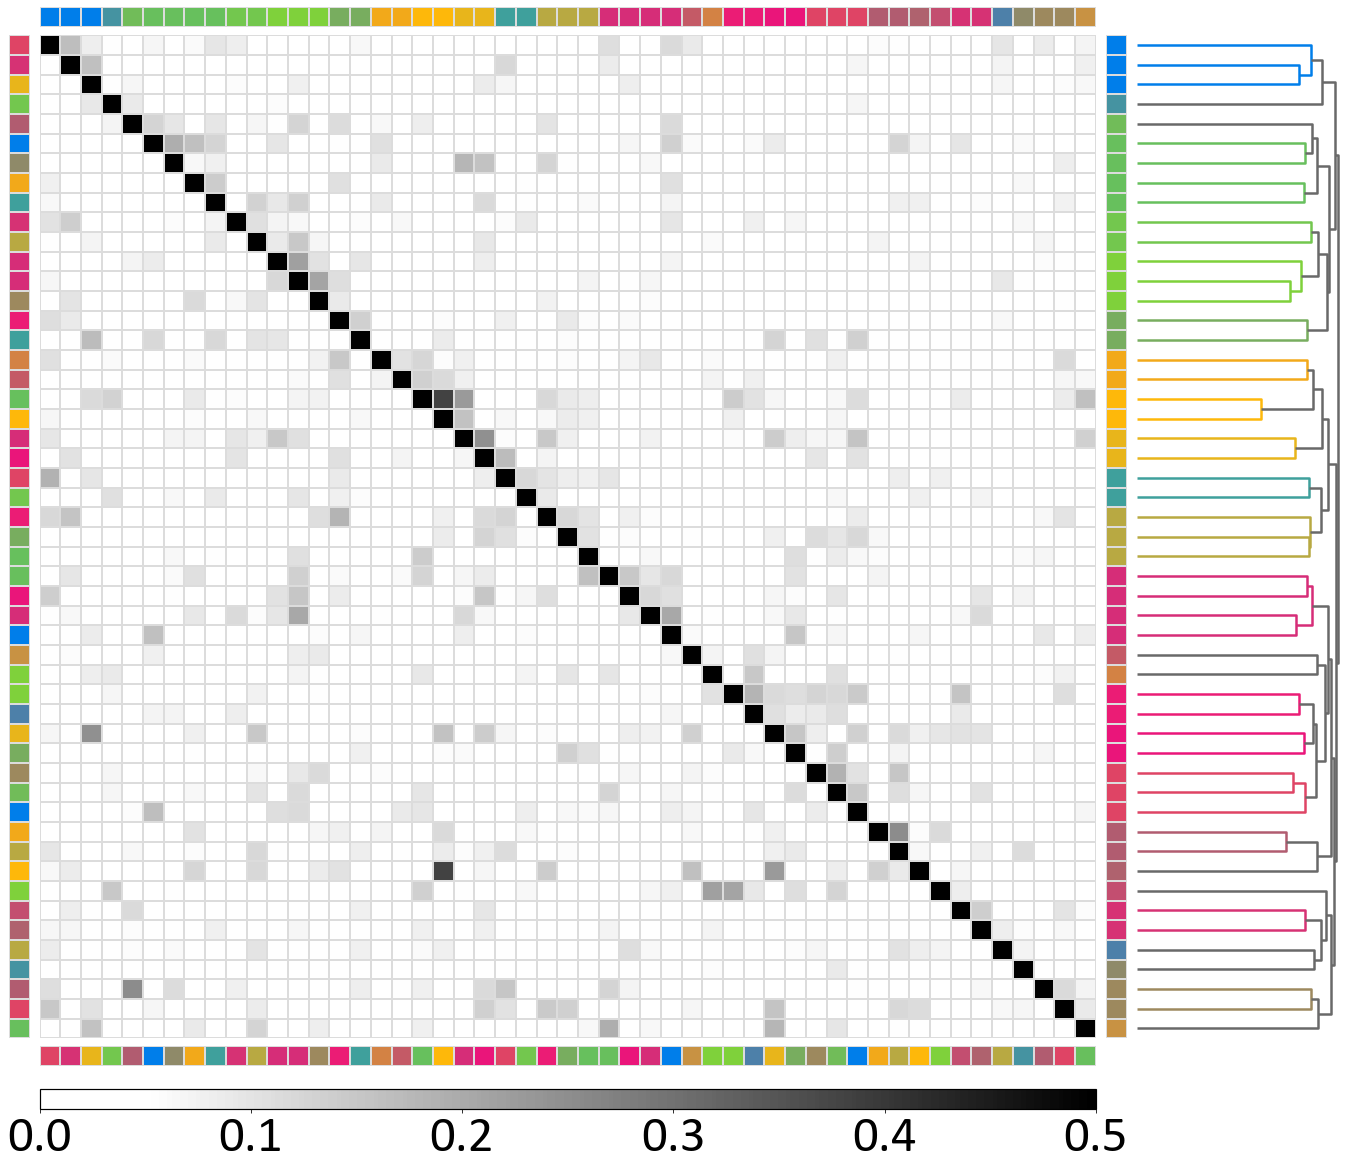

In [30]:
# HCK SH3 domain:
aligned_seq = 'VVALYDYEAIHHEDLSFQKGDQMVVLEE-SGEWWKARSTRKEGYIPSNYVA'
raw_seq = "SEDIIVVALYDYEAIHHEDLSFQKGDQMVVLEESGEWWKARSLATRKEGYIPSNYVARVDS" # Stats at Canonical Position 78
alignment = map_to_structure(aligned_seq, raw_seq, 23)

output_dir = "plots/fig_4_5_supp_fig_5_6/SH3/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

clustermap, colormap = map_to_colorscale("SH3", alignment, output_dir=output_dir, colors=sh3_reordered_colors)

for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

Alignment for overlapping domain structures in Fig. 4c. Note, the code does not automatically save the heatmaps associated with these figures (these are the same as the heatmap is computed at a sequence-independent level). 

Colot threshold of 0.873 results in max silhouette score of 0.05
With threshold of 0.873415:     9 singletons,    18 non-singletons
set_color resi44, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi44, domain & Q64010_132_192_1CKA & resi 44;
set_color resi9, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi9, domain & Q64010_132_192_1CKA & resi 9;
set_color resi34, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi34, domain & Q64010_132_192_1CKA & resi 34;
set_color resi52, [0.26957131445122257, 0.5756841663635355, 0.6306677745642175]
color resi52, domain & Q64010_132_192_1CKA & resi 52;
set_color resi43, [0.44349161422826106, 0.739033831550777, 0.34819554642876355]
color resi43, domain & Q64010_132_192_1CKA & resi 43;
set_color resi31, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi31, domain & Q64010_132_192_1CKA & resi 31;
set_color resi55, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi55, domain & Q64010_132_

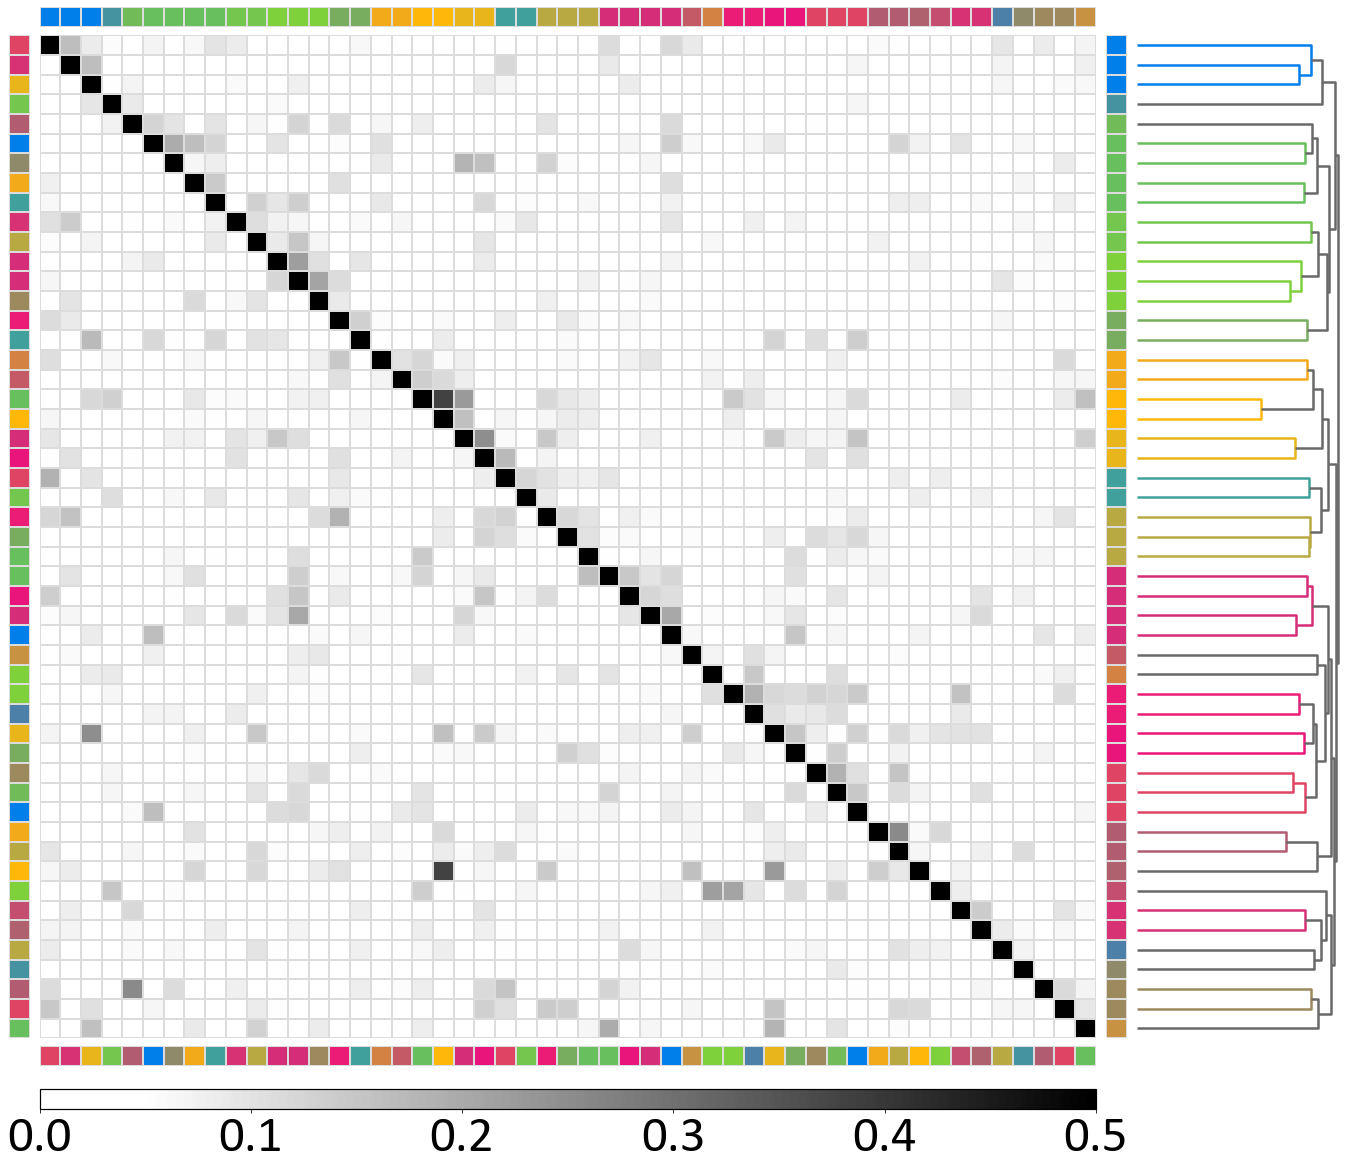

In [45]:
aligned_seq = 'VRALFDFNGNDEEDLPFKKGDILRIRDKPEEQWWNAEDEGKRGMIPVPYVE'
raw_seq = "EEAEYVRALFDFNGNDEEDLPFKKGDILRIRDKPEEQWWNAEDSEGKRGMIPVPYVEKYRP" # Stats at Canonical Position 78
alignment = map_to_structure(aligned_seq, raw_seq, -1)
clustermap, colormap = map_to_colorscale("SH3", alignment, colors=sh3_reordered_colors);
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & Q64010_132_192_1CKA & resi {0};".format(k))

Colot threshold of 0.873 results in max silhouette score of 0.05
With threshold of 0.873415:     9 singletons,    18 non-singletons
set_color resi248, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi248, domain & P06241_82_143_1FYN & resi 48
set_color resi212, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi212, domain & P06241_82_143_1FYN & resi 12
set_color resi237, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi237, domain & P06241_82_143_1FYN & resi 37
set_color resi256, [0.26957131445122257, 0.5756841663635355, 0.6306677745642175]
color resi256, domain & P06241_82_143_1FYN & resi 56
set_color resi247, [0.44349161422826106, 0.739033831550777, 0.34819554642876355]
color resi247, domain & P06241_82_143_1FYN & resi 47
set_color resi234, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi234, domain & P06241_82_143_1FYN & resi 34
set_color resi259, [0.4076207892991134, 0.7506359873449712, 0.3641060334115302]
color resi259, domain & P06241

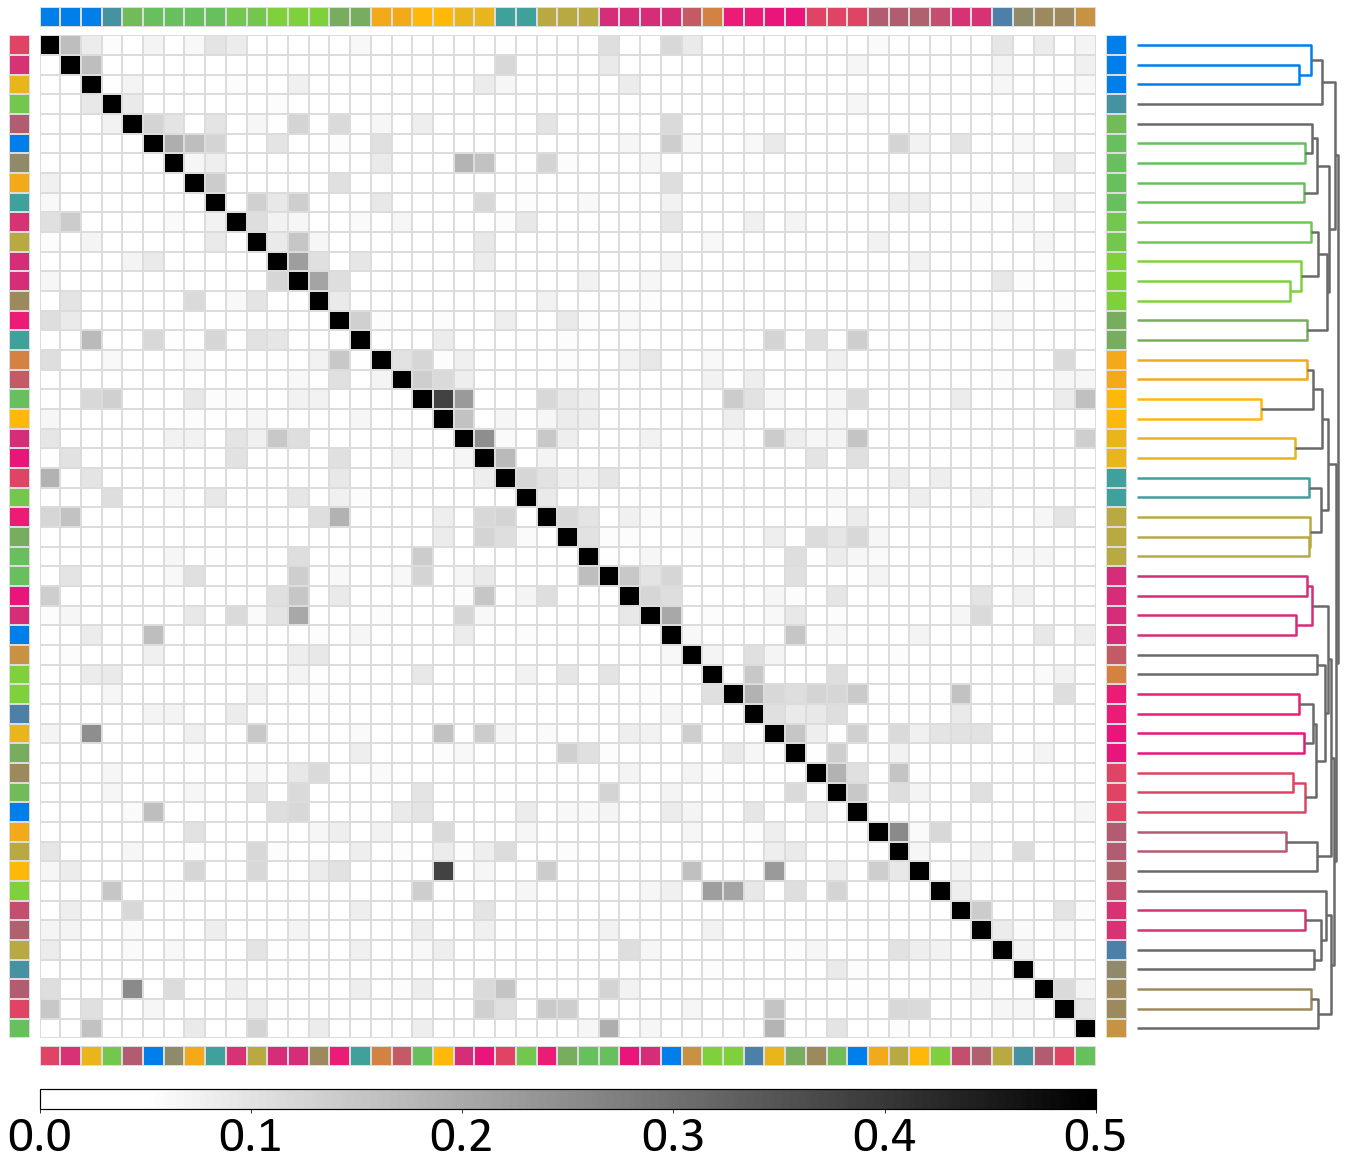

In [54]:
aligned_seq = 'FVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSTGETGYIPSNYVA'
raw_seq = "TGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPVDS" # Stats at Canonical Position 78
alignment = map_to_structure(aligned_seq, raw_seq, 2)
clustermap, colormap = map_to_colorscale("SH3", alignment, colors=sh3_reordered_colors);
for k,v in colormap.items():
    print("set_color resi2{0}, {1}".format(k, v))
    print("color resi2{0}, domain & P06241_82_143_1FYN & resi {0}".format(k))

Analysis of the specific residues from the paper. Plots as simple heatmap w/ some re-ordering of amino acid in order to have a more meaningful ordering. 

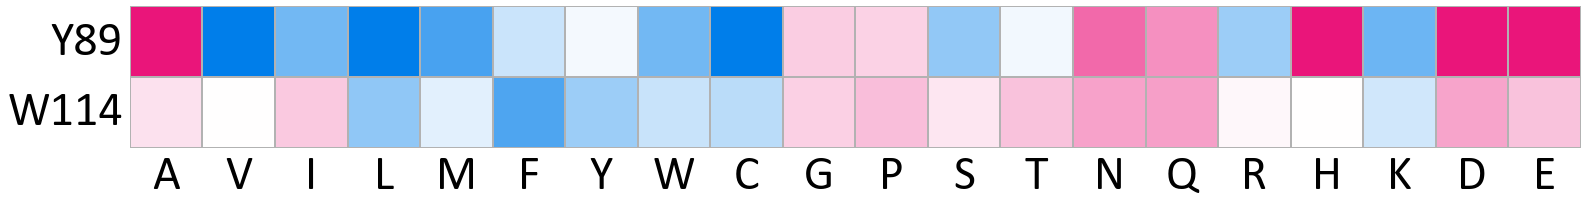

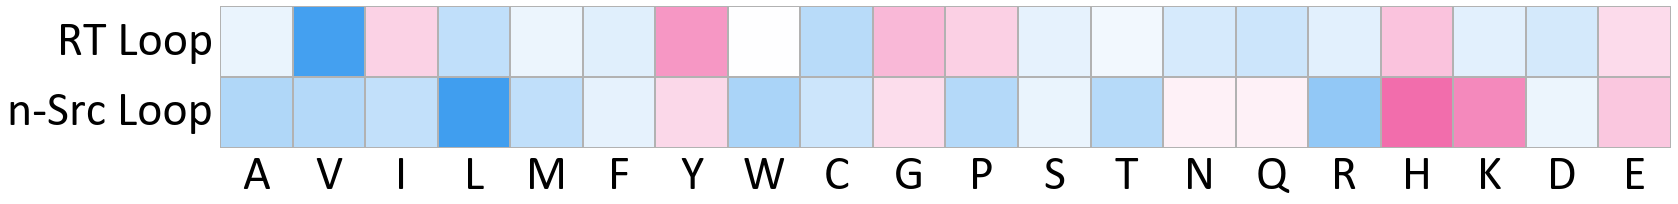

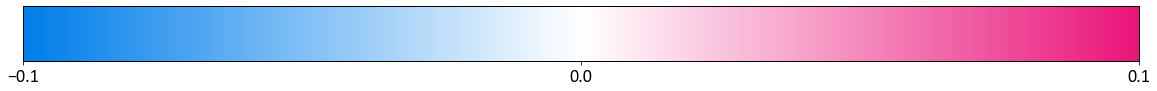

In [13]:
maqCoolWarm_r = LinearSegmentedColormap.from_list("maqCoolWarm_r", [pink, 'w', blue])
vmax=0.02
vmin=-vmax
def plot_interacting_residue(arr, row_labels, re_idxed=_r, idxing=aa_idxing, vmin=vmin, vmax=vmax,
                             cmap=maqCoolWarm_r, plot_pY=False):
    """
    Plots a heatmap of specific domain positions. 
    
    arr: plotted array
    row_labels:  
    re_idxed: re-ordered amino acids (relative to model order) for prettier plotting. 
    - n.b. Defined in data-loading code. This is really bad style...
    idxing: map of amino acid to order in model
    
    
    Returns:
        matplotlib figure with plotted energy functions. 
    """
    
    _inv = {i:aa for aa,i in idxing.items()}
    
    if not plot_pY:
        re_idxed = [r for r in re_idxed if r != idxing['y']]       
    naa = len(re_idxed)
    
    # Expand dimensions of array if single dimension. Necessary to work w/ Seaborn's heatmap function
    if len(arr.shape)==1: arr = np.expand_dims(arr, 0)
    
    # Plotting function
    f, ax = plt.subplots(figsize=(26, arr.shape[0] * (26/naa)))
    sns.heatmap(arr[:,re_idxed], yticklabels=row_labels, xticklabels=[_inv[i].replace('y', 'pY') for i in re_idxed], ax=ax,
               center=0, vmin=vmin, vmax=vmax, cmap=cmap, cbar=False, linewidth=2.0, linecolor="#B2B2B2")
    
    ax.tick_params(axis='both', which='major', labelsize=48, labelrotation=0)
    
    return f

sh3_weights = np.matmul(hsmd_weights["SH3"], basis).reshape(domain_lengths["SH3"], peptide_lengths["SH3"], 21,21)

# Selects for the specific residue in the domain at each of the following positions.
# Modify in setting of changes to the ordering of the underlying model. 
arrs, names = list(), list()
for didx, pidx, aa_idx, name in [(6,2,19,"Y89"), (32,2,18,"W114")]: 
    #fig = plot_interacting_residue(sh3_weights[didx, pidx][aa_idx], [name])
    #print(max(np.abs(sh3_weights[didx, pidx][aa_idx])))   
    arrs.append(sh3_weights[didx, pidx][aa_idx])
    names.append(name)
   
output_dir = "plots/fig_4_5_supp_fig_5_6/SH3/"

fig = plot_interacting_residue(np.vstack(arrs), names)
fig.savefig(os.path.join(output_dir, "{0}.pdf".format("_".join(names))), dpi=500, transparent=True, bbox_inches='tight')
    
rtLoop = np.mean(np.vstack([sh3_weights[didx, :, pidx] for didx, pidx in [(10,6), (11,6), (12,3), (13,2)]]), axis=0)
#fig = plot_interacting_residue(rtLoop, ["RT Loop"])
#fig.savefig(os.path.join(output_dir, "rt.mean.pdf"), dpi=500, transparent=True, bbox_inches='tight')

nsrcLoop = np.mean(np.vstack([sh3_weights[didx, :, pidx] for didx, pidx in [(26,3), (27,3), (29,15), (30,5), (31,3)]]), axis=0)
#fig = plot_interacting_residue(nsrcLoop, ["n-Src Loop"])
#fig.savefig(os.path.join(output_dir,"nsrc.mean.pdf"), dpi=500, transparent=True, bbox_inches='tight')

fig = plot_interacting_residue(np.vstack([rtLoop, nsrcLoop]), ["RT Loop", "n-Src Loop"])
fig.savefig(os.path.join(output_dir,"rt_nsrc.mean.pdf"), dpi=500, transparent=True, bbox_inches='tight')

# Colormap plotted
fig, ax = plt.subplots(figsize=(20,1))
ColorbarBase(ax, cmap=maqCoolWarm, norm=Normalize(vmin=-.1, vmax=.1), orientation='horizontal', ticks=[-.1, 0, .1])
fig.savefig(os.path.join(output_dir, "colorbar.energy_heatmaps.pdf"), dpi=500, transparent=True, bbox_inches='tight')

## WH1

Colot threshold of 0.517 results in max silhouette score of 0.60
With threshold of 0.516541:     8 singletons,    29 non-singletons
set_color resi86, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi86, domain & resi 86
set_color resi48, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi48, domain & resi 48
set_color resi49, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi49, domain & resi 49
set_color resi58, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi58, domain & resi 58
set_color resi59, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi59, domain & resi 59
set_color resi12, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi12, domain & resi 12
set_color resi65, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi65, domain & resi 65
set_color resi68, [0.9176470355274827, 0.08235295609613696, 0.4784313804522056]
colo

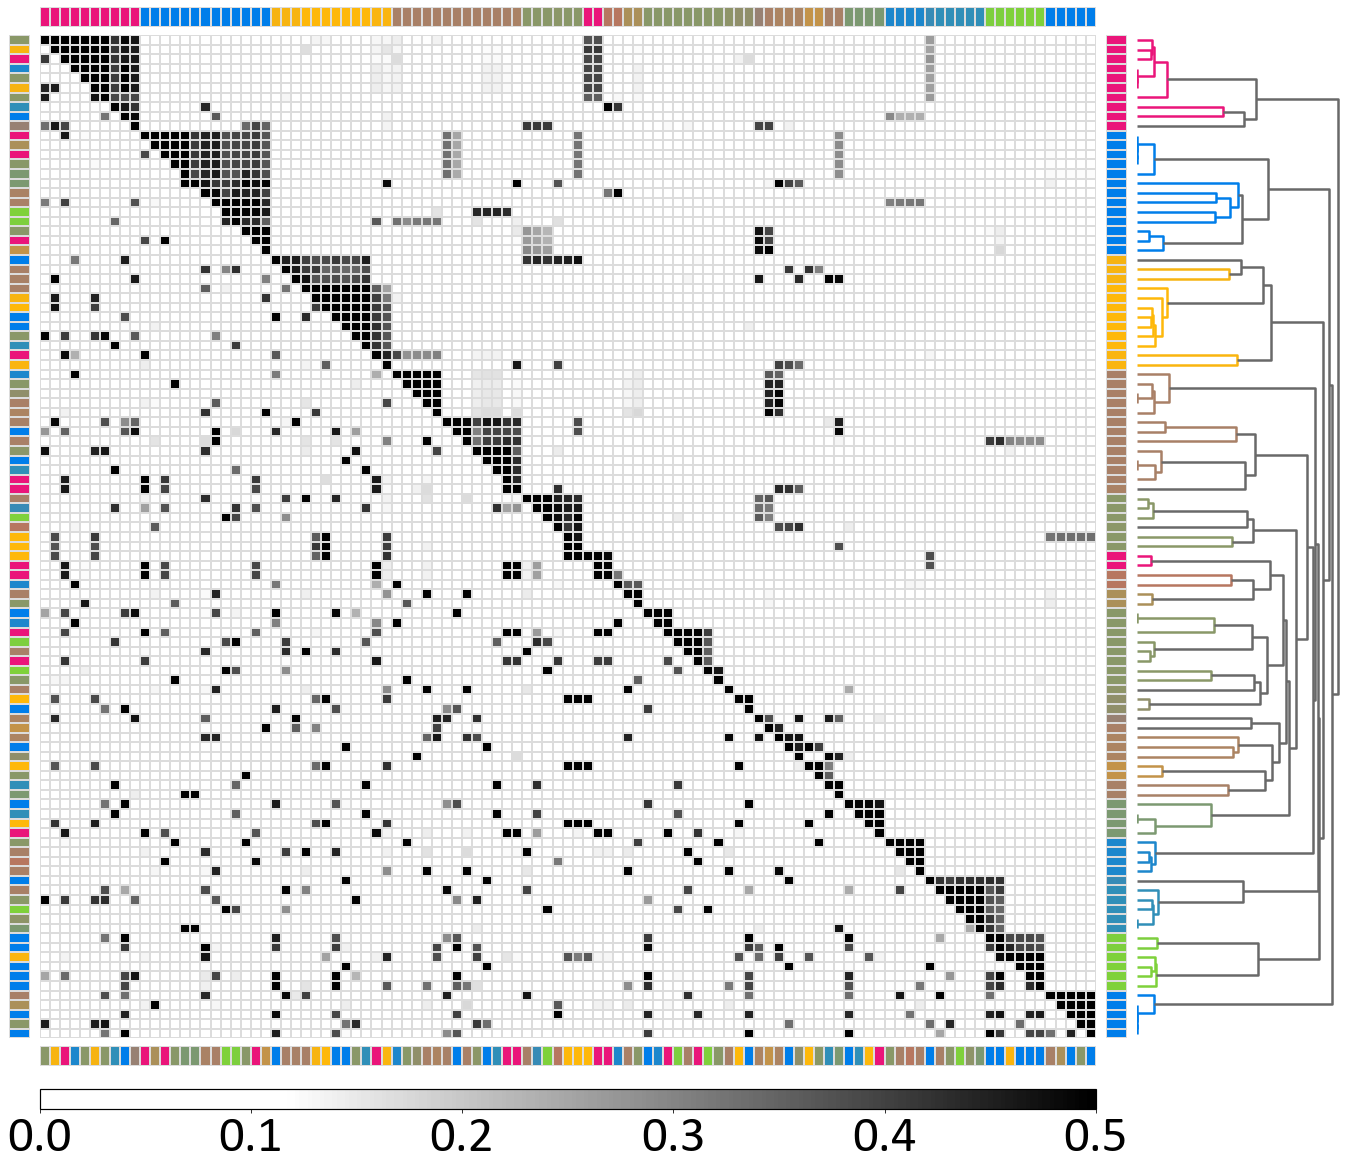

In [55]:
# EVL WH1 Domain, (PDB structure is from mouse, differs at one residue (N44S))
aligned_seq = 'SQSICQARASVMVYDDTSKKWVPIKPGQQGFSRINIYHNTASNTFRVVGVKLQQQVVINYSIVKGLKYNQATPTFHQWRDARQVYGLNFASKEEATTFSNAMLFA'
raw_seq = "MSEQSICQARASVMVYDDTSKKWVPIKPGQQGFSRINIYHNTASNTFRVVGVKLQDQQVVINYSIVKGLKYNQATPTFHQWRDARQVYGLNFASKEEATTFSNAMLFALNIM" # Starts at Canonical Position 1
alignment = map_to_structure(aligned_seq, raw_seq, 0)

output_dir = "plots/fig_4_5_supp_fig_5_6/WH1/"
if not os.path.exists(output_dir): os.makedirs(output_dir)
    
clustermap, colormap = map_to_colorscale("WH1", alignment, output_dir=output_dir)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## WW

Colot threshold of 0.874 results in max silhouette score of 0.15
With threshold of 0.873877:     0 singletons,    12 non-singletons
set_color resi8, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi8, domain & resi 8
set_color resi30, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi30, domain & resi 30
set_color resi33, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi33, domain & resi 33
set_color resi3, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi3, domain & resi 3
set_color resi5, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi5, domain & resi 5
set_color resi17, [0.09676346310717068, 0.5536856079286702, 0.7879314060608478]
color resi17, domain & resi 17
set_color resi32, [0.09676346310717068, 0.5536856079286702, 0.7879314060608478]
color resi32, domain & resi 32
set_color resi9, [0.32824701325398176, 0.6654853297149366, 0.5146587697022252]
color resi9, domain & resi 9
set_color resi25, [0.32824701325398

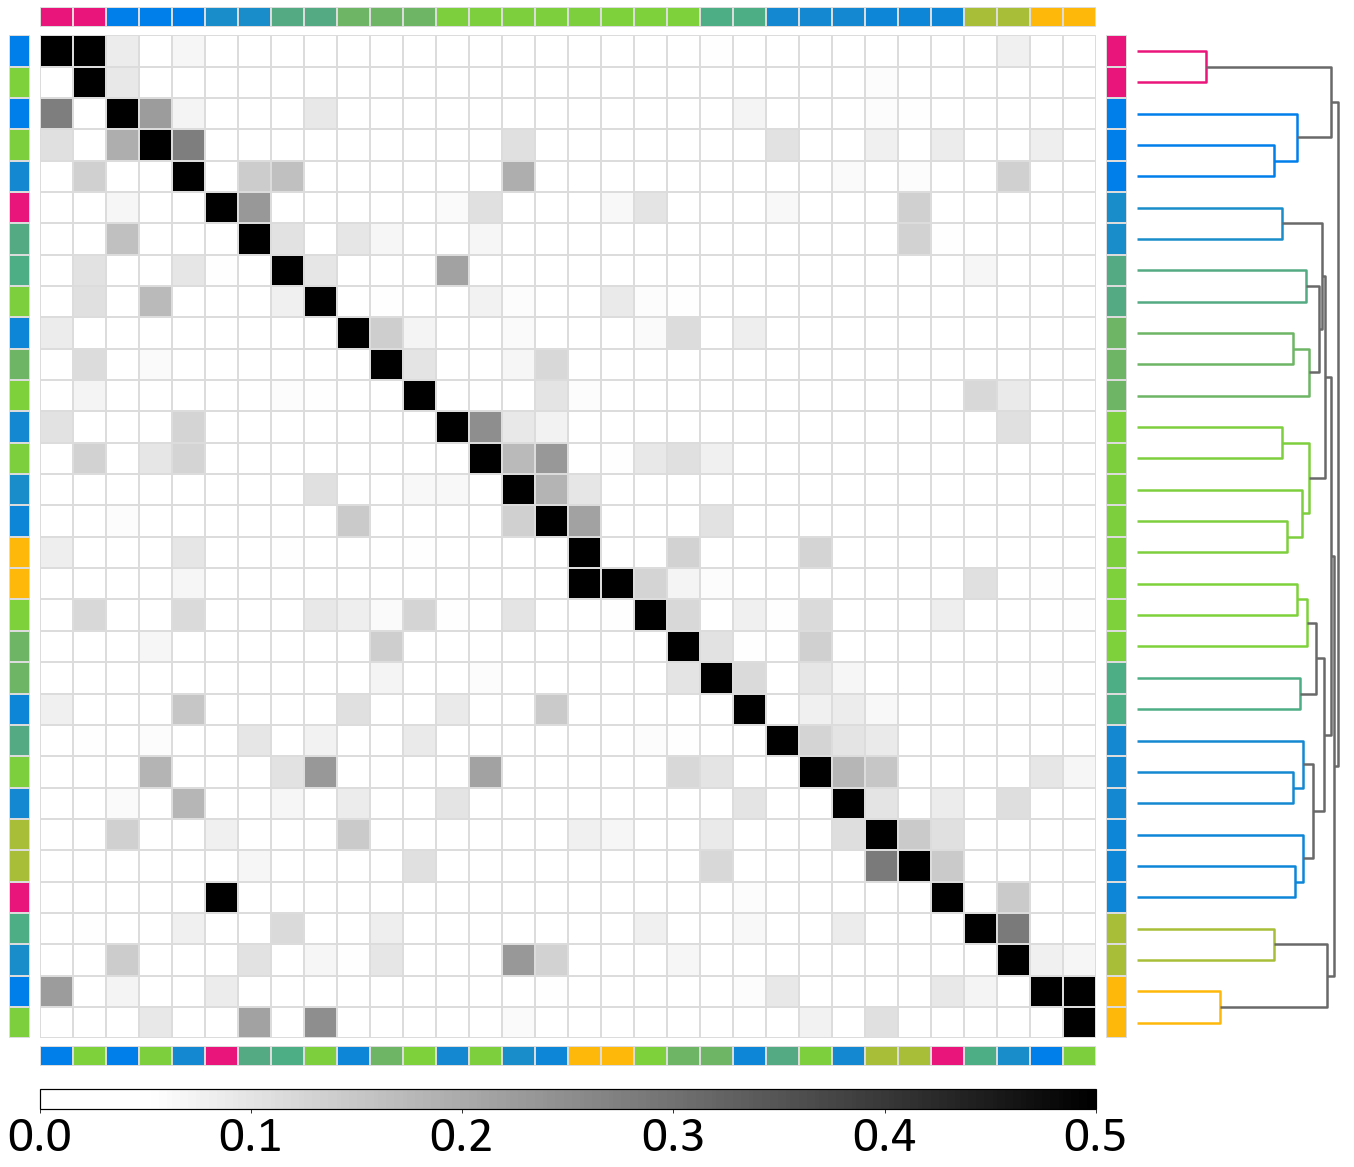

In [56]:
# SMURF1 WW Domain
aligned_seq = 'PLPPGWEVRSTVSGRIYFVDHNNRTTQFTDPR'
raw_seq = "GPLPPGWEVRSTVSGRIYFVDHNNRTTQFTDPRL" # Starts at Canonical Position 1
alignment = map_to_structure(aligned_seq, raw_seq, 2)

output_dir = "plots/fig_4_5_supp_fig_5_6/WW/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

clustermap, colormap = map_to_colorscale("WW", alignment, output_dir=output_dir)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## SH2

Colot threshold of 0.942 results in max silhouette score of 0.04
With threshold of 0.942078:     0 singletons,    22 non-singletons
set_color resi24, [0.5720880167837141, 0.7471415671880199, 0.2594357762160426]
color resi24, domain & resi 24
set_color resi74, [0.5720880167837141, 0.7471415671880199, 0.2594357762160426]
color resi74, domain & resi 74
set_color resi91, [0.5720880167837141, 0.7471415671880199, 0.2594357762160426]
color resi91, domain & resi 91
set_color resi10, [0.5720880167837141, 0.7471415671880199, 0.2594357762160426]
color resi10, domain & resi 10
set_color resi28, [0.5720880167837141, 0.7471415671880199, 0.2594357762160426]
color resi28, domain & resi 28
set_color resi98, [0.490005153775718, 0.6780373237227725, 0.3762702825608975]
color resi98, domain & resi 98
set_color resi47, [0.490005153775718, 0.6780373237227725, 0.3762702825608975]
color resi47, domain & resi 47
set_color resi76, [0.490005153775718, 0.6780373237227725, 0.3762702825608975]
color resi76, domain &

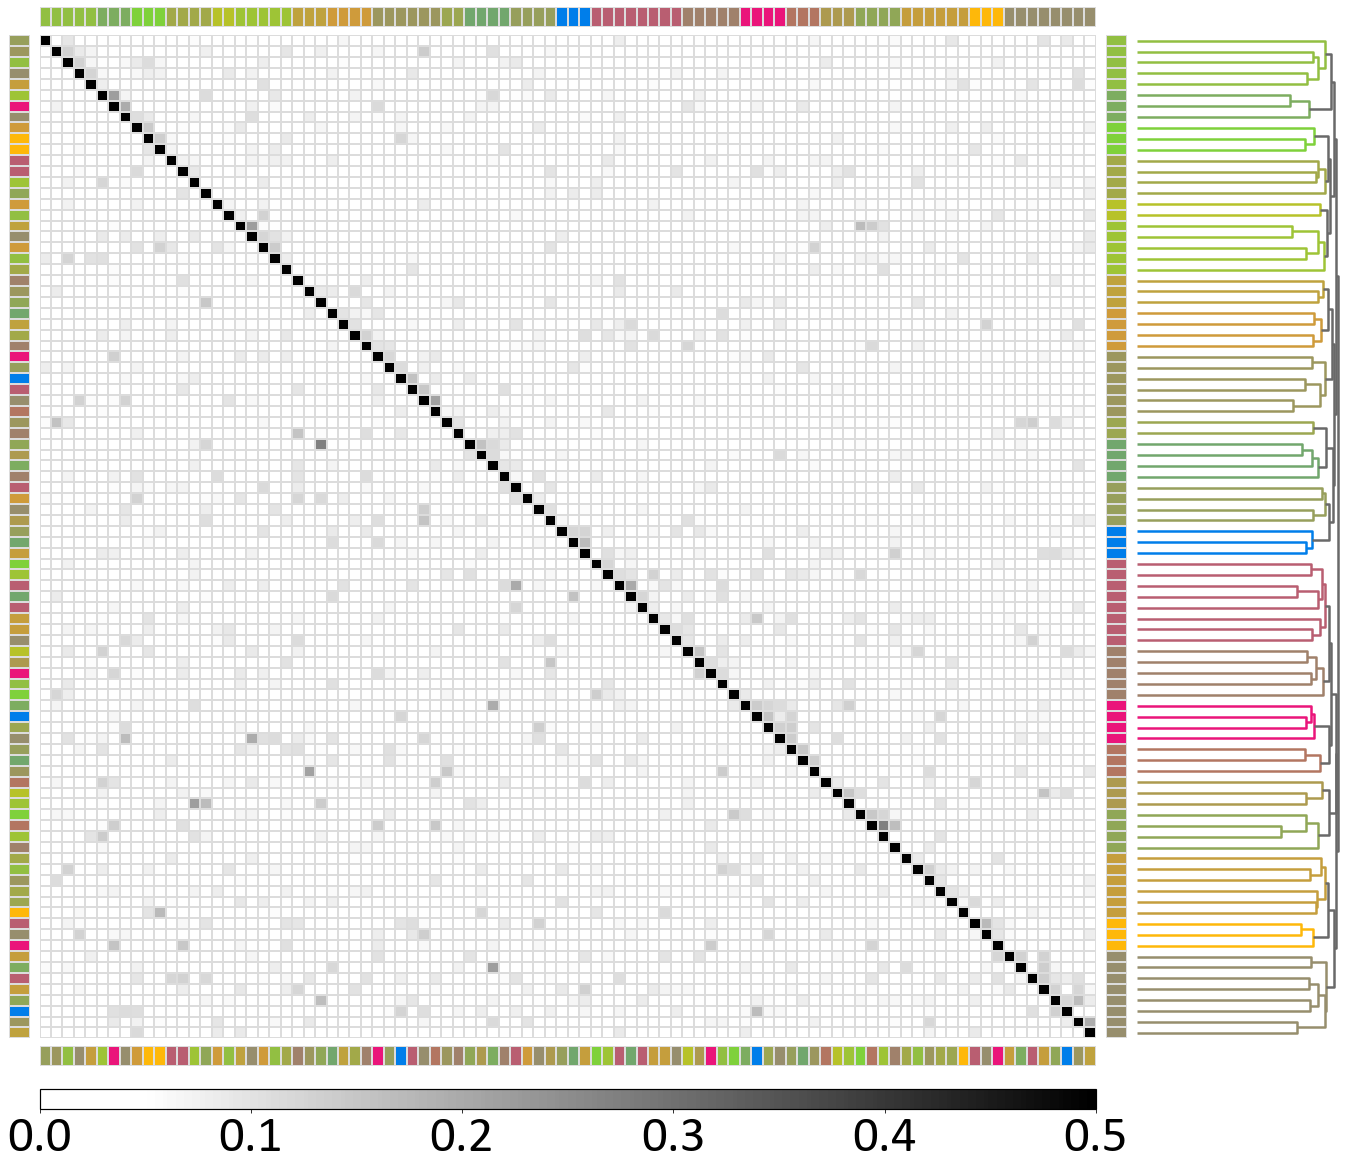

In [57]:
aligned_seq = 'WYHGHMSGGQAETLLQAKGEPWTFLVRESLSQPGDFVLSV-LSGGSVTHIKVMCEG-GRYTV-GGLEFDSLTDLVEHF-KKTG-IEEASGAF'
raw_seq = "WYHGHMSGGQAETLLQAKGEPWTFLVRESLSQPGDFVLSVLSDQPKAGPGSPLRVTHIKVMCEGGRYTVGGLETFDSLTDLVEHFKKTGIEEASGAFVYLRQPY" # Starts at Canonical Position 1
alignment = map_to_structure(aligned_seq, raw_seq, 8)

output_dir = "plots/fig_4_5_supp_fig_5_6/SH2/"
if not os.path.exists(output_dir): os.makedirs(output_dir)
    
clustermap, colormap = map_to_colorscale("SH2", alignment, output_dir=output_dir)

for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## PTB

With threshold of  0.83:     0 singletons,     5 non-singletons
set_color resi149, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi149, domain & resi 149
set_color resi185, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi185, domain & resi 185
set_color resi69, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi69, domain & resi 69
set_color resi175, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi175, domain & resi 175
set_color resi153, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi153, domain & resi 153
set_color resi37, [0.996078431372549, 0.7215686274509804, 0.0392156862745098]
color resi37, domain & resi 37
set_color resi46, [0.996078431372549, 0.7215686274509804, 0.0392156862745098]
color resi46, domain & resi 46
set_color resi183, [0.996078431372549, 0.7215686274509804, 0.0392156862745098]
color resi183, domain & resi 183
set_color resi171, [0.0, 0.4941176

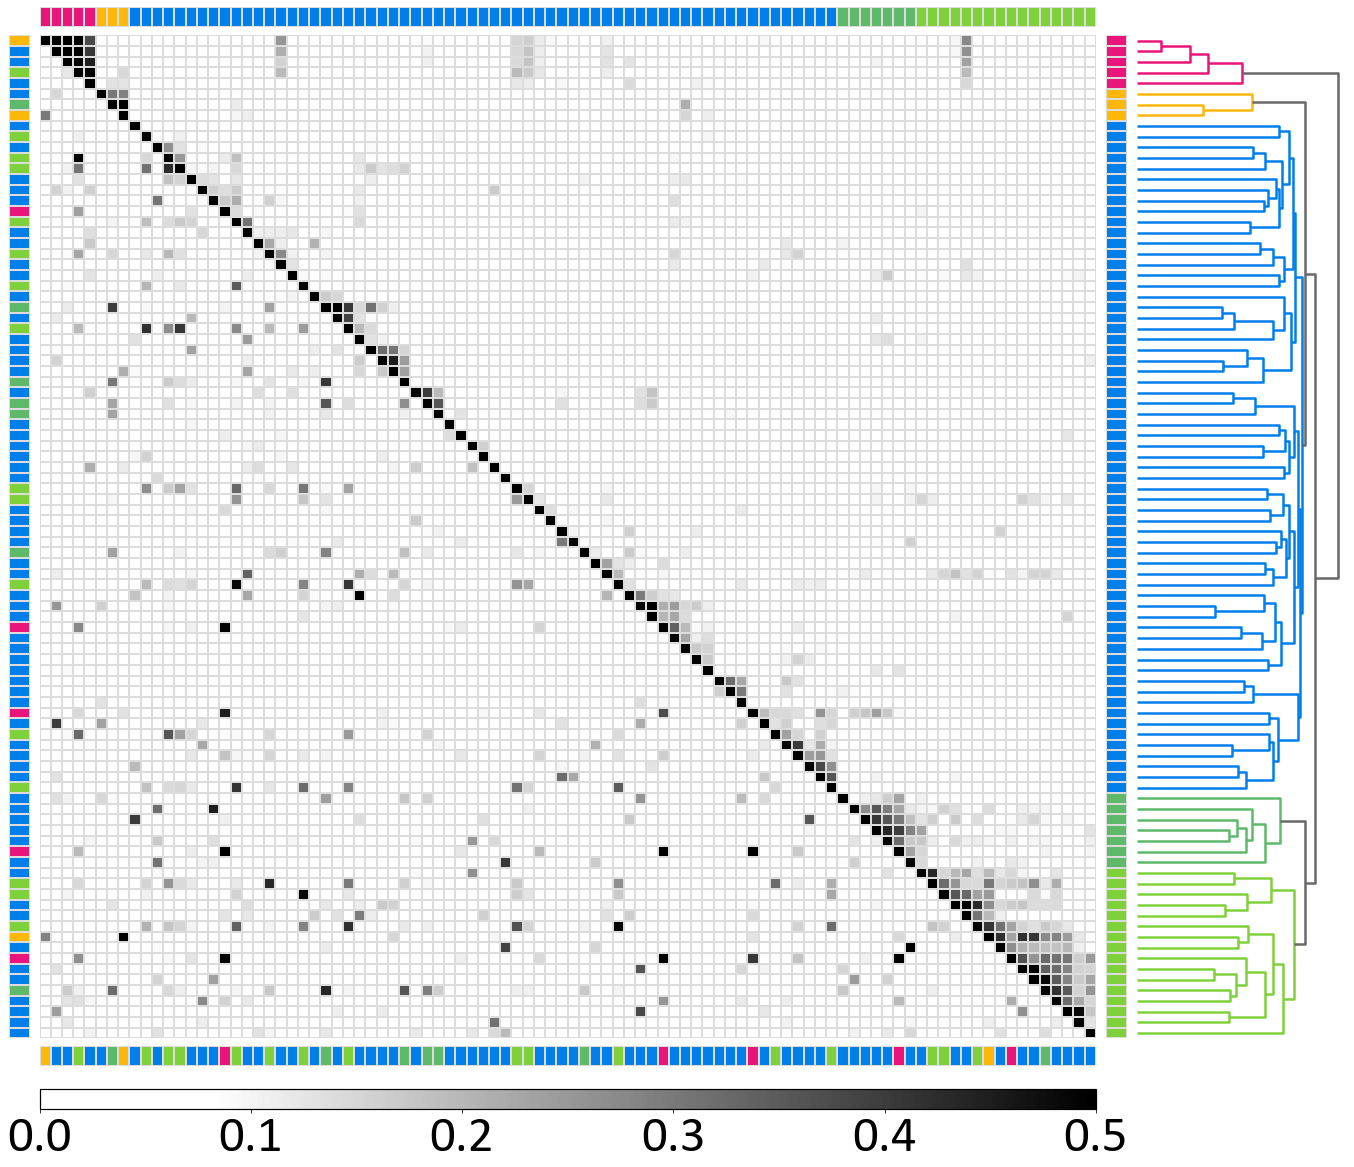

In [65]:
aligned_seq = 'GYLVRYMGCVEVVTREAISLVMPITLTVSTSSLNLMAADCKQIIANHHMQSISF-A-------AYVRACHILECPEAQDVISTIGQAFELRFKQ'
raw_seq = 'MGPGVSYLVRYMGCVEVLQSMRALDFNTRTQVTREAISLVCEAVPGAKGATRRRKPCSRPLSSILGRSNLKFAGMPITLTVSTSSLNLMAADCKQIIANHHMQSISFASGGDPDTAEYVAYVAKDPVNQRACHILECPEGLAQDVISTIGQAFELRFKQYLRNPPKLVTPHDRMAGFDGSAWDE'
alignment = map_to_structure(aligned_seq, raw_seq, 34)

output_dir = "plots/fig_4_5_supp_fig_5_6/PTB/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

clustermap, colormap = map_to_colorscale("PTB", alignment, output_dir=output_dir, color_threshold=0.83)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## Kinase_TK

With threshold of   0.6:     0 singletons,    31 non-singletons
set_color resi202, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi202, domain & resi 202
set_color resi272, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi272, domain & resi 272
set_color resi207, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi207, domain & resi 207
set_color resi373, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi373, domain & resi 373
set_color resi204, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi204, domain & resi 204
set_color resi334, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi334, domain & resi 334
set_color resi383, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi383, domain & resi 383
set_color resi314, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi314, domain & resi 314
set_color resi368, [0.0, 0.49411

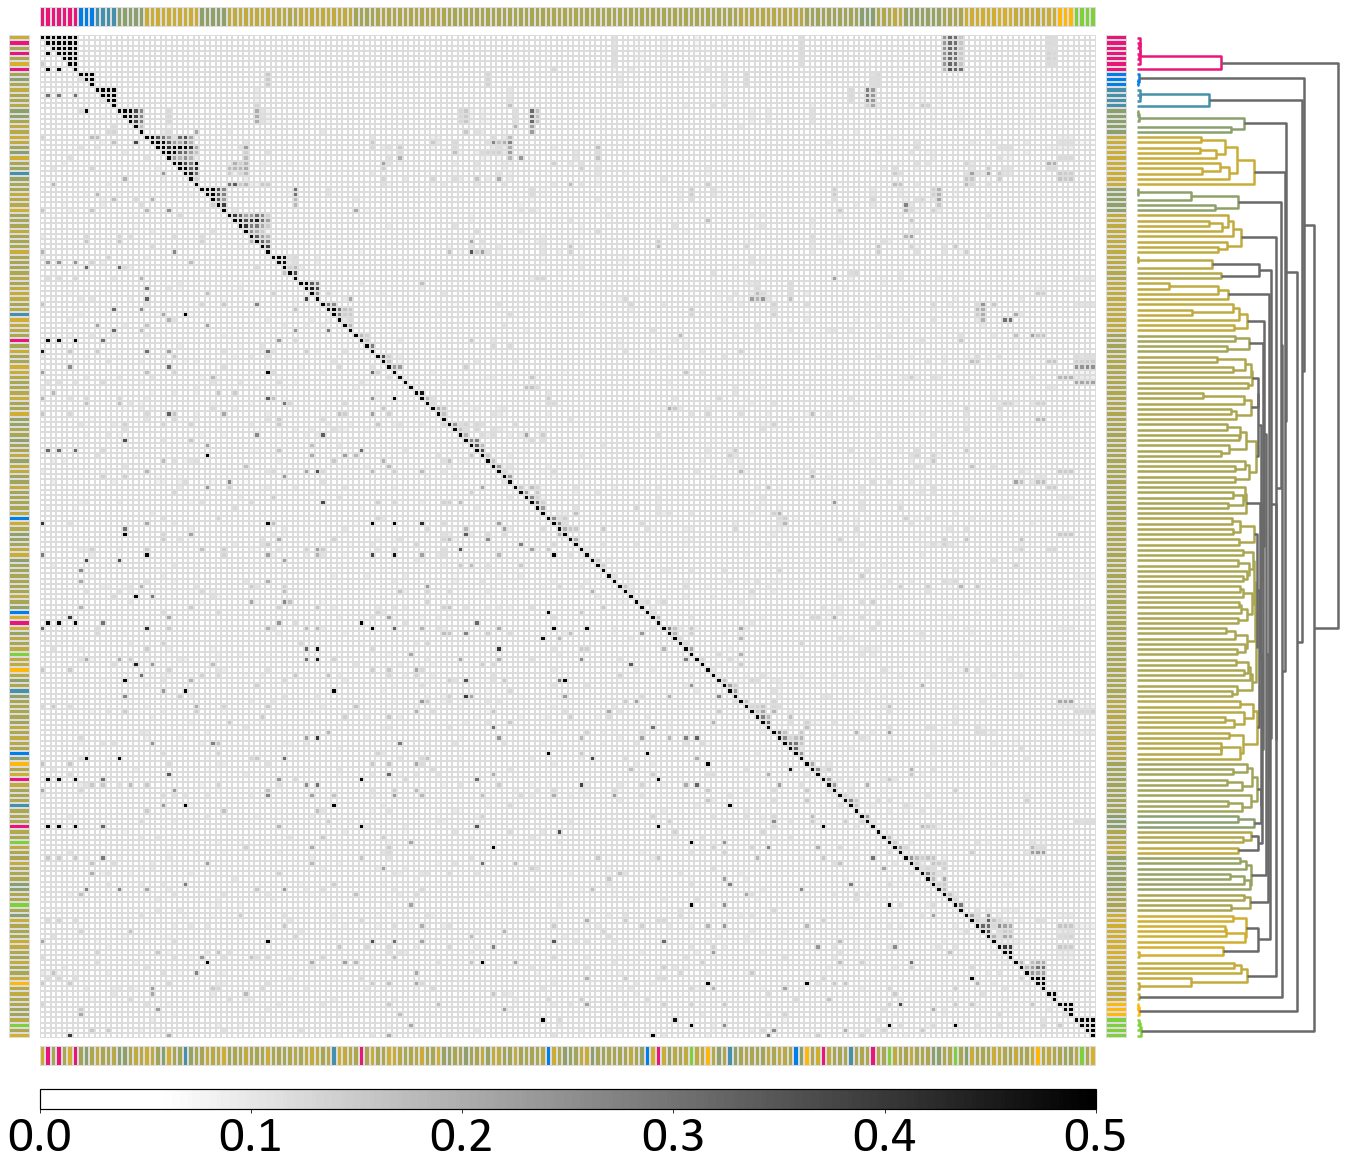

In [70]:
aligned_seq = 'IGKGEFGDVMLGDKVAVKCIKQAFLAEASVMTQLRHSNLVQLLGVIVELYIVTEYMAKGSLVDYLRSDCLLKFSLDVCEAMEYLEGNNFVHRDLAARNVLVSEDNVAKVSDFGLTKE-PVKWTAPEALREKKFSTKSDVWSFGILLWEIYSGRVPYPRIPLKDVPDGCPPAVYEVMKNCWHLDAAMRPSF'
raw_seq = "LKLLQTIGKGEFGDVMLGDYRGNKVAVKCIKNDATAQAFLAEASVMTQLRHSNLVQLLGVIVEEKGGLYIVTEYMAKGSLVDYLRSRGRSVLGGDCLLKFSLDVCEAMEYLEGNNFVHRDLAARNVLVSEDNVAKVSDFGLTKEASSTQDTGKLPVKWTAPEALREKKFSTKSDVWSFGILLWEIYSFGRVPYPRIPLKDVVPRVEKGYKMDAPDGCPPAVYEVMKNCWHLDAAMRPSFLQLREQLEHIKTHELH"

alignment = map_to_structure(aligned_seq, raw_seq, 195)

output_dir = "plots/fig_4_5_supp_fig_5_6/Kinase_TK/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

clustermap, colormap = map_to_colorscale("Kinase_TK", alignment, output_dir=output_dir, color_threshold=0.6)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## PTP

Colot threshold of 0.622 results in max silhouette score of 0.30
With threshold of 0.622443:     3 singletons,    27 non-singletons
set_color resi200, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi200, domain & resi 200
set_color resi177, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi177, domain & resi 177
set_color resi172, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi172, domain & resi 172
set_color resi122, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi122, domain & resi 122
set_color resi83, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi83, domain & resi 83
set_color resi85, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi85, domain & resi 85
set_color resi180, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi180, domain & resi 180
set_color resi171, [0.996078431372549, 0.7215686274509804, 0.03921568

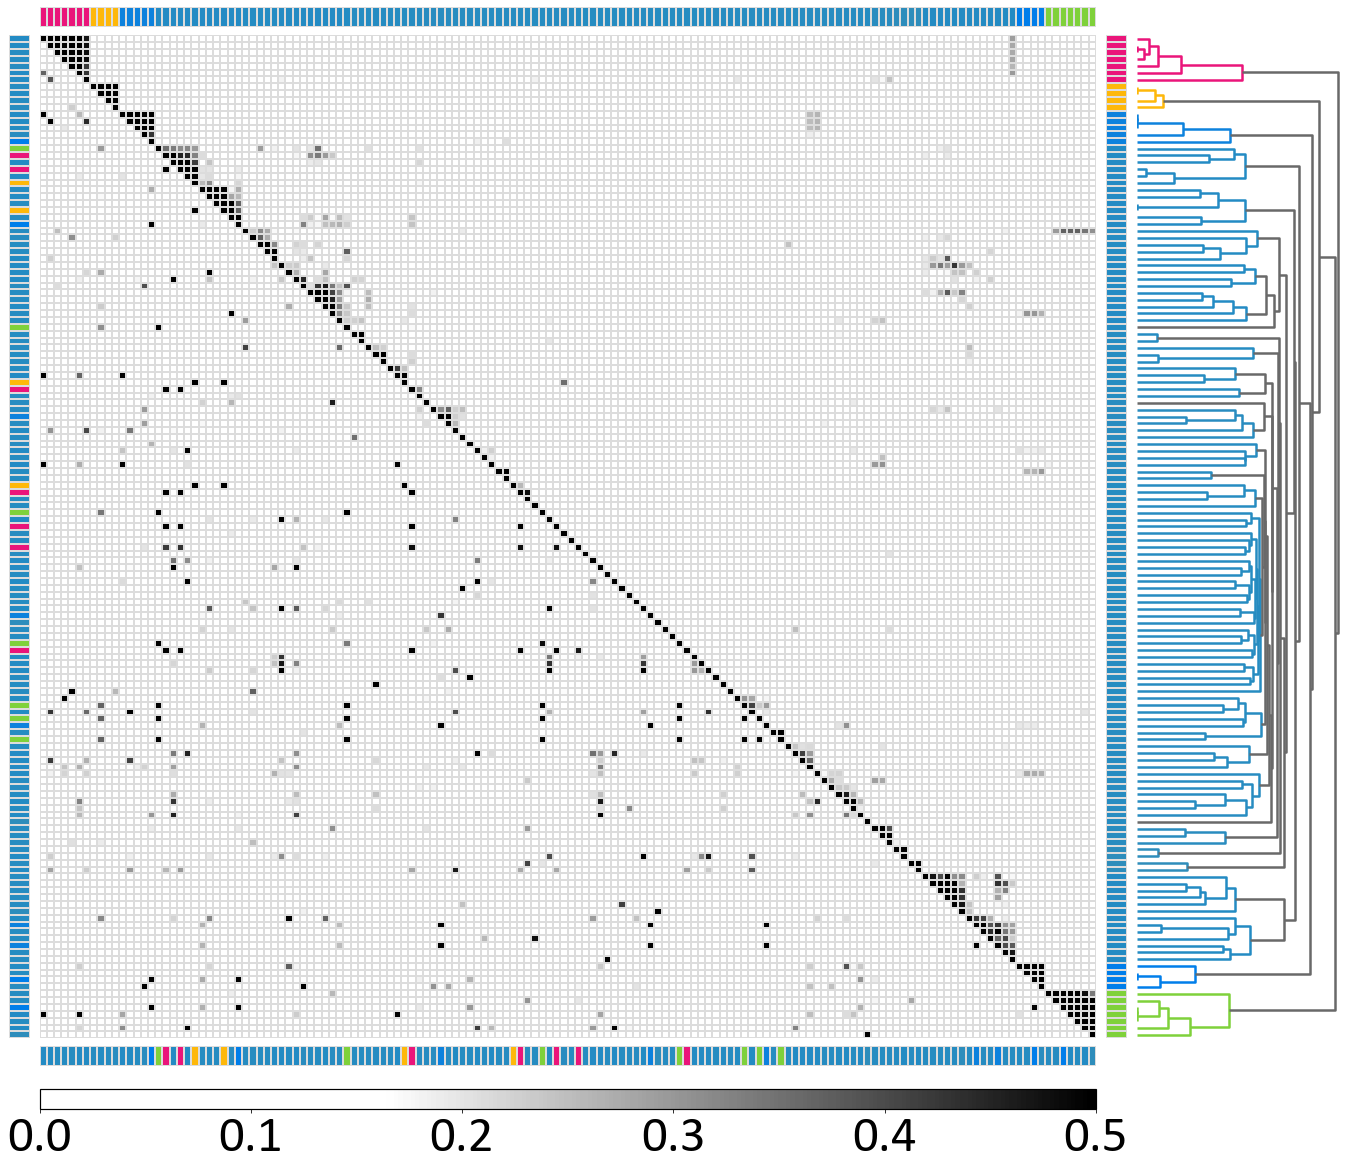

In [69]:
aligned_seq = 'YINGNFIRGVAYIATQGPLPFWRLVWEFGVKVILMACREIENGRKRCERYWAQESRSVYQLQYMSWPDRGVPSSPDMLAMVEEARRGPEPLCVHCSAGCGRTGVLCTVDYVRQLLLPPDFSLFDVVLKMRKQRPAAVQTEEQYRFL'
raw_seq = 'LAGEFSDIQACSAAWKADGVCSTVAGSRPENVRKNRYKDVLPYDQTRVILSLLQEEGHSDYINGNFIRGVDGSLAYIATQGPLPHTLLDFWRLVWEFGVKVILMACREIENGRKRCERYWAQEQEPLQTGLFCITLIKEKWLNEDIMLRTLKVTFQKESRSVYQLQYMSWPDRGVPSSPDHMLAMVEEARRLQGSGPEPLCVHCSAGCGRTGVLCTVDYVRQLLLTQMIPPDFSLFDVVLKMRKQRPAAVQTEEQYRFLYHTVAQM'
alignment = map_to_structure(aligned_seq, raw_seq, 2)

output_dir = "plots/fig_4_5_supp_fig_5_6/PTP/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

clustermap, colormap = map_to_colorscale("PTP", alignment, output_dir=output_dir)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

## PDZ

Colot threshold of 0.934 results in max silhouette score of 0.05
With threshold of 0.934493:     0 singletons,    14 non-singletons
set_color resi82, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi82, domain & resi 82
set_color resi22, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi22, domain & resi 22
set_color resi21, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi21, domain & resi 21
set_color resi63, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi63, domain & resi 63
set_color resi45, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi45, domain & resi 45
set_color resi16, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi16, domain & resi 16
set_color resi55, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi55, domain & resi 55
set_color resi14, [0.4980392156862745, 0.8196078431372549, 0.23137254901960785]
color resi1

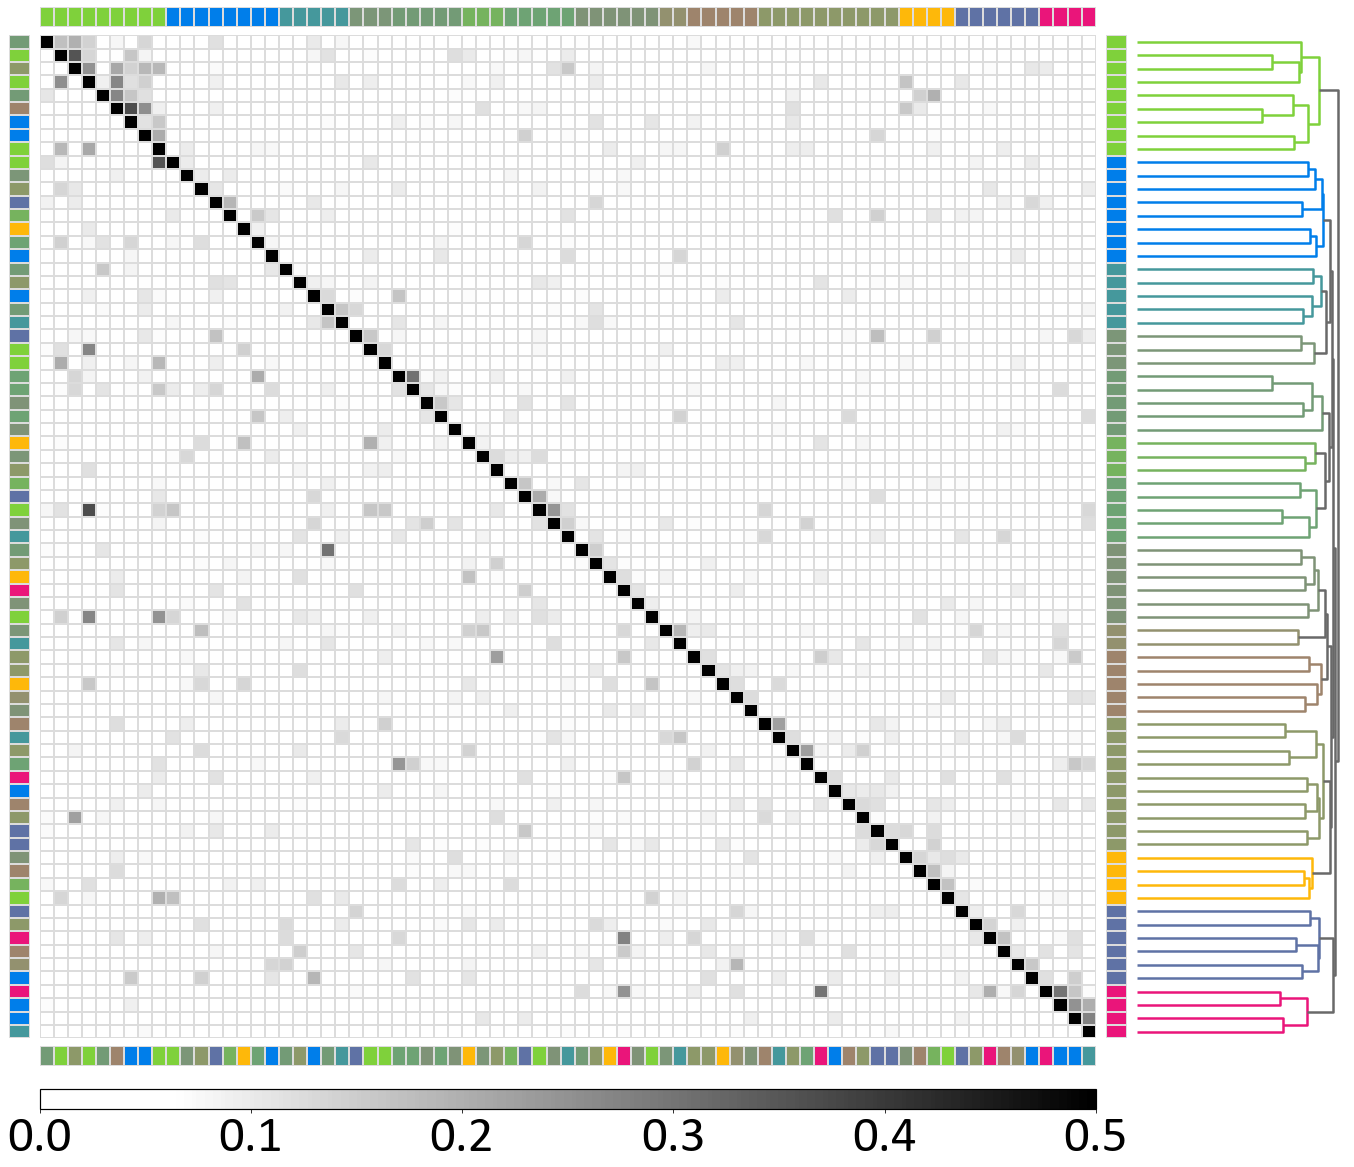

In [71]:
# ERBIN PDZ Domain
aligned_seq = '-ELGFSISGGVGDDGIFVTRVQPEGPASKL--LQPGDKIIQANGYSFINIEHGQAVSLLKTF--QNTVELII---'
raw_seq = 'EIRVRVEKDPELGFSISGGVGGRGNPFRPDDDGIFVTRVQPEGPASKLLQPGDKIIQANGYSFINIEHGQAVSLLKTFQNTVELIIVREV'
alignment = map_to_structure(aligned_seq, raw_seq, 4)

output_dir = "plots/fig_4_5_supp_fig_5_6/PDZ/"
if not os.path.exists(output_dir): os.makedirs(output_dir)
    
clustermap, colormap = map_to_colorscale("PDZ", alignment, output_dir=output_dir)
for k,v in colormap.items():
    print("set_color resi{0}, {1}".format(k, v))
    print("color resi{0}, domain & resi {0}".format(k))

# SH3 Energy Analysis

This computes the energy surface as a function of the average energy. The output domain structures are stored in data/structures/figure_5.

To prepare, one can use a fairly similar set of commands to the prior output with an added surface. 

~~~
set cartoon_side_chain_helper, on;

remove hydrogens;

set_color maqpink, [0.9140625, 0.08203125, 0.4765625]; set_color maqgreen, [0.49609375, 0.81640625, 0.23046875]; set_color maqorange, [0.9921875, 0.71875, 0.0390625]; set_color maqblue, [0, 0.494, 0.918]; set_color lightGray, [ 0.863, 0.863, 0.863 ]; set_color maqpurple, [0.45703125, 0.2890625, 0.6953125];

bg_color white; set ray_trace_fog,0; set ray_shadows,0; set antialias,1; set ray_trace_mode, 0;

one_letter ={'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', 'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',  'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A', 'GLY':'G', 'PRO':'P', 'CYS':'C'}

select domain, chain A
select peptide, chain B

color lightGray, domain
color black, peptide

set stick_transparency, 0.5, peptide
show_as sticks, peptide


create peptide_s, peptide
remove peptide
show_as sticks, peptide_s
show surface, domain


set stick_transparency, 0.5, peptide
show_as sticks, peptide

create peptide_s, peptide
remove peptide
show_as sticks, peptide_s
show surface, domain
~~~

In [75]:
coolwarm_cmap = LinearSegmentedColormap.from_list("coolwarm_maq", colors=[pink, 'w', blue])
def color_by_average(dtype, poffs, pep, alignment, sele, struct, dist=2.5, take_min=False,
                     weights=hsmd_weights, basis=basis, dlengths=domain_lengths, plengths=peptide_lengths,
                     cmap = coolwarm_cmap, vmin=-0.1, vmax=0.1):
    """
    Colors an input domain structure by the given structure distance threshold.
    
    dtype: domain type - used to load weights
    poffs: offset of input peptide to max alignment
    pep: input peptide sequence
    alignment: input domain - PDB sequence alignment
    sele: object to select in the domain. Used in the output print. 
    struct: input PDB structure of domain-peptide
    dist: distance ball around each domain residue to consider
    take_min: an option for computing the energy based on only the closest residue. Note, this is not used. 
    ... Plotting Arguments
    
    Returns:
        prints out the max energy computed over the alignment at the given distance.
    
    """
    
    # Load in domain weights. Structure is (dlen, plen, daa_idx, paa_idx)
    ws = np.matmul(weights[dtype], basis).reshape((dlengths[dtype], plengths[dtype], 21, 21))
    
    # Load structure into data
    # Note, this isn't particularly error tolerant to variable PDB structures. May need to update 
    parser = PDBParser()
    s = parser.get_structure('{0}_struct'.format(dtype), struct)
    domain, peptide = s[0]['A'], s[0]['B']
    
    inv_alignment = {struct_details[0]:idx for idx, struct_details in alignment.items()}
    
    # Maps domains to the correct index in the underlying model. 
    domain_residue_map, peptide_residue_map = dict(), dict()
    for dres in domain.get_residues():
        dres_id = dres.get_id()[1]
        if dres_id in inv_alignment:
            domain_residue_map[inv_alignment[dres_id]] = dres
    
    # Map peptide residues to correct indices in the underlying model. 
    for pres, (pidx, paa) in zip(peptide.get_residues(), enumerate(pep)):
        peptide_residue_map[pidx] = pres
    
    
    # Computes distance based on closest atom between any two residues
    get_dist = lambda dres, pres: min(np.linalg.norm(pres_atom.get_coord() - dres_atom.get_coord()) 
                                      for dres_atom, pres_atom in product(dres.get_atoms(), pres.get_atoms()))
    
    N = Normalize(vmin=vmin, vmax=vmax)
    for didx, dres in domain_residue_map.items():
        # Get all residues within ball (or take_min option)
        if take_min: within_radius = [min(peptide_residue_map.items(), key=lambda tup: get_dist(dres, tup[1]))[0]]
        else: within_radius = [pidx for pidx, pres in peptide_residue_map.items() if get_dist(dres, pres) <= dist]
        
        if len(within_radius) == 0: continue
            
        # Extract the adjacent residues and output mean.
        struct_didx, dres, _ = alignment[didx]
        dres_offs = aa_idxing[dres]
        e = np.mean([ws[didx, pidx + poffs, dres_offs, aa_idxing[pep[pidx]]] for pidx in within_radius])
        
        # This takes advantage of matplotlib's color functions - Normalize (see above) and the input colormap
        c = list(cmap(N(e))[:-1])
        
        print("set_color resi{0}, {1}".format(struct_didx, c))
        print("color resi{0}, domain & {1} & resi {0}".format(struct_didx, sele))

In [73]:
# HCK SH3 domain:
aligned_seq = 'VVALYDYEAIHHEDLSFQKGDQMVVLEE-SGEWWKARSTRKEGYIPSNYVA'
raw_seq = "SEDIIVVALYDYEAIHHEDLSFQKGDQMVVLEESGEWWKARSLATRKEGYIPSNYVARVDS" # Stats at Canonical Position 78
alignment = map_to_structure(aligned_seq, raw_seq, 23)

proline_peptide = "HSKYPLPPLPSL" 

input_structure = "data/structures/P08631_78_138_2OI3.pdb"

In [76]:
color_by_average("SH3", 0, proline_peptide, alignment, "P08631_78_138_2OI3", input_structure, dist=2.5, vmin=-0.025, vmax=0.025, take_min=False)

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 988
  warnings.warn(
/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1184
  warnings.warn(


set_color resi32, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi32, domain & P08631_78_138_2OI3 & resi 32
set_color resi34, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi34, domain & P08631_78_138_2OI3 & resi 34
set_color resi37, [0.9195847750865052, 0.1039446366782007, 0.4907035755478662]
color resi37, domain & P08631_78_138_2OI3 & resi 37
set_color resi38, [0.9803921568627451, 0.990080738177624, 0.9983852364475202]
color resi38, domain & P08631_78_138_2OI3 & resi 38
set_color resi39, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi39, domain & P08631_78_138_2OI3 & resi 39
set_color resi40, [0.5568627450980392, 0.7758246828143023, 0.9635063437139562]
color resi40, domain & P08631_78_138_2OI3 & resi 40
set_color resi41, [0.965444059976932, 0.6149480968858131, 0.7811457131872357]
color resi41, domain & P08631_78_138_2OI3 & resi 41
set_color resi58, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi58, domain & P08631_

In [77]:
color_by_average("SH3", 0, proline_peptide, alignment, "P08631_78_138_2OI3", input_structure, dist=5, vmin=-0.025, vmax=0.025, take_min=False)

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 988
  warnings.warn(
/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1184
  warnings.warn(


set_color resi31, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi31, domain & P08631_78_138_2OI3 & resi 31
set_color resi32, [0.5254901960784314, 0.7599538638985006, 0.9609227220299884]
color resi32, domain & P08631_78_138_2OI3 & resi 32
set_color resi33, [0.49411764705882355, 0.744083044982699, 0.9583391003460208]
color resi33, domain & P08631_78_138_2OI3 & resi 33
set_color resi34, [0.9176470588235294, 0.08235294117647059, 0.47843137254901963]
color resi34, domain & P08631_78_138_2OI3 & resi 34
set_color resi37, [0.9835294117647059, 0.8164705882352942, 0.895686274509804]
color resi37, domain & P08631_78_138_2OI3 & resi 37
set_color resi38, [0.982237600922722, 0.802076124567474, 0.8875048058439061]
color resi38, domain & P08631_78_138_2OI3 & resi 38
set_color resi39, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi39, domain & P08631_78_138_2OI3 & resi 39
set_color resi40, [0.42352941176470593, 0.7083737024221454, 0.9525259515570934]
color resi40, domain & P08631_78

In [78]:
color_by_average("SH3", 0, proline_peptide, alignment, "P08631_78_138_2OI3", input_structure, dist=10, vmin=-0.025, vmax=0.025, take_min=False)

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 988
  warnings.warn(
/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1184
  warnings.warn(


set_color resi29, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi29, domain & P08631_78_138_2OI3 & resi 29
set_color resi30, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi30, domain & P08631_78_138_2OI3 & resi 30
set_color resi31, [0.6823529411764706, 0.8393079584775087, 0.9738408304498269]
color resi31, domain & P08631_78_138_2OI3 & resi 31
set_color resi32, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi32, domain & P08631_78_138_2OI3 & resi 32
set_color resi33, [0.9333333333333333, 0.9662745098039216, 0.9945098039215686]
color resi33, domain & P08631_78_138_2OI3 & resi 33
set_color resi34, [0.9945098039215686, 0.9388235294117647, 0.9652287581699346]
color resi34, domain & P08631_78_138_2OI3 & resi 34
set_color resi35, [0.0, 0.49411764705882355, 0.9176470588235294]
color resi35, domain & P08631_78_138_2OI3 & resi 35
set_color resi36, [0.956401384083045, 0.5141868512110727, 0.7238754325259515]
color resi36, domain & P08631_78_138_2OI3 & resi 36
set_color

In [79]:
color_by_average("SH3", 0, proline_peptide, alignment, "P08631_78_138_2OI3", input_structure, dist=10000, vmin=-0.025, vmax=0.025, take_min=False)

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 988
  warnings.warn(
/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1184
  warnings.warn(


set_color resi28, [0.9492964244521338, 0.43501730103806224, 0.678877354863514]
color resi28, domain & P08631_78_138_2OI3 & resi 28
set_color resi29, [0.8784313725490196, 0.9385005767012687, 0.9899884659746251]
color resi29, domain & P08631_78_138_2OI3 & resi 29
set_color resi30, [0.44705882352941173, 0.7202768166089966, 0.9544636678200692]
color resi30, domain & P08631_78_138_2OI3 & resi 30
set_color resi31, [0.6823529411764706, 0.8393079584775087, 0.9738408304498269]
color resi31, domain & P08631_78_138_2OI3 & resi 31
set_color resi32, [0.3137254901960784, 0.6528258362168398, 0.9434832756632064]
color resi32, domain & P08631_78_138_2OI3 & resi 32
set_color resi33, [0.9333333333333333, 0.9662745098039216, 0.9945098039215686]
color resi33, domain & P08631_78_138_2OI3 & resi 33
set_color resi34, [0.9019607843137255, 0.9504036908881199, 0.9919261822376009]
color resi34, domain & P08631_78_138_2OI3 & resi 34
set_color resi35, [0.09411764705882353, 0.5417301038062283, 0.9253979238754325]
co

# Plots for Figures:

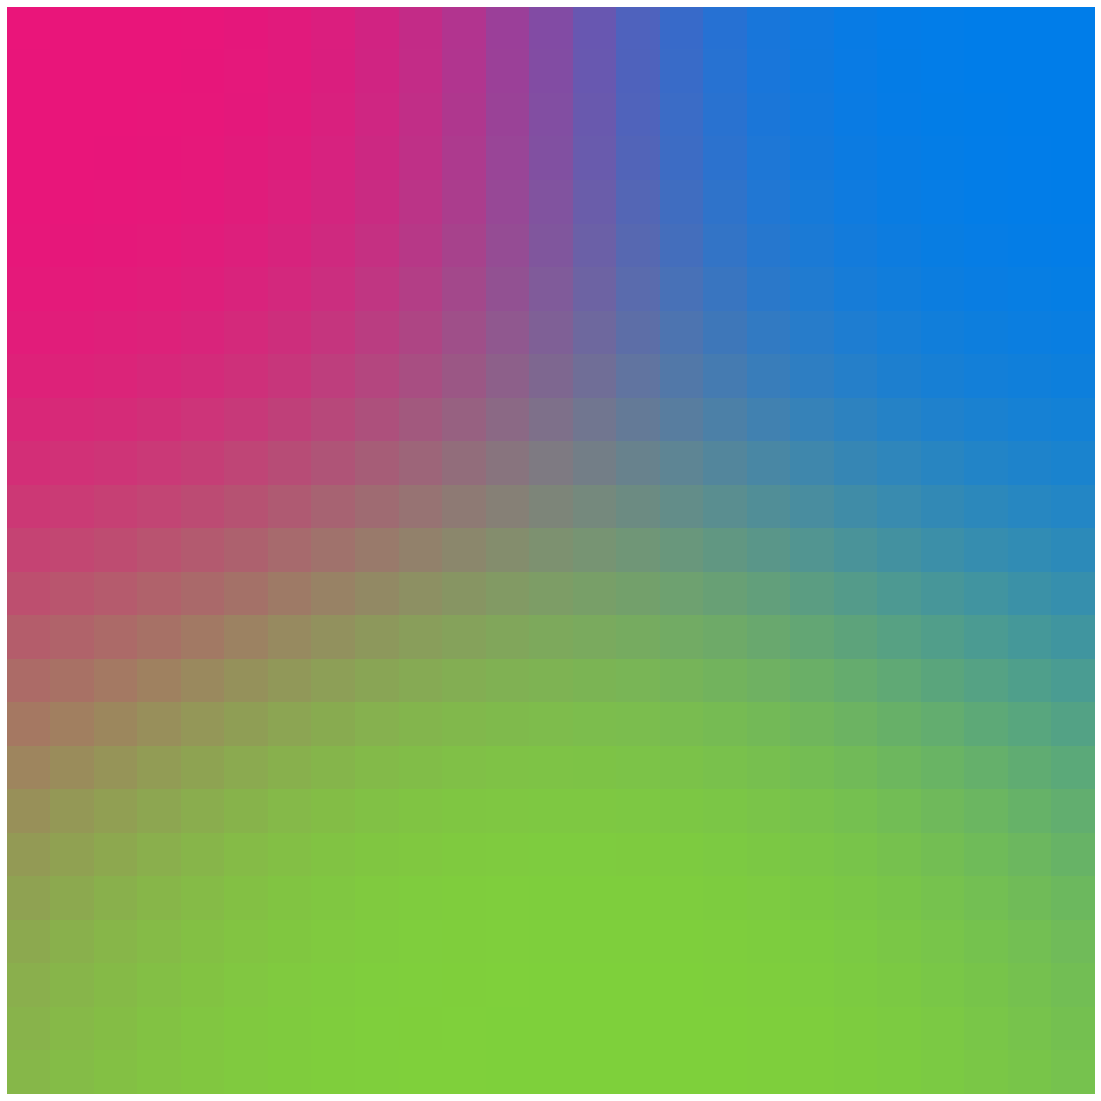

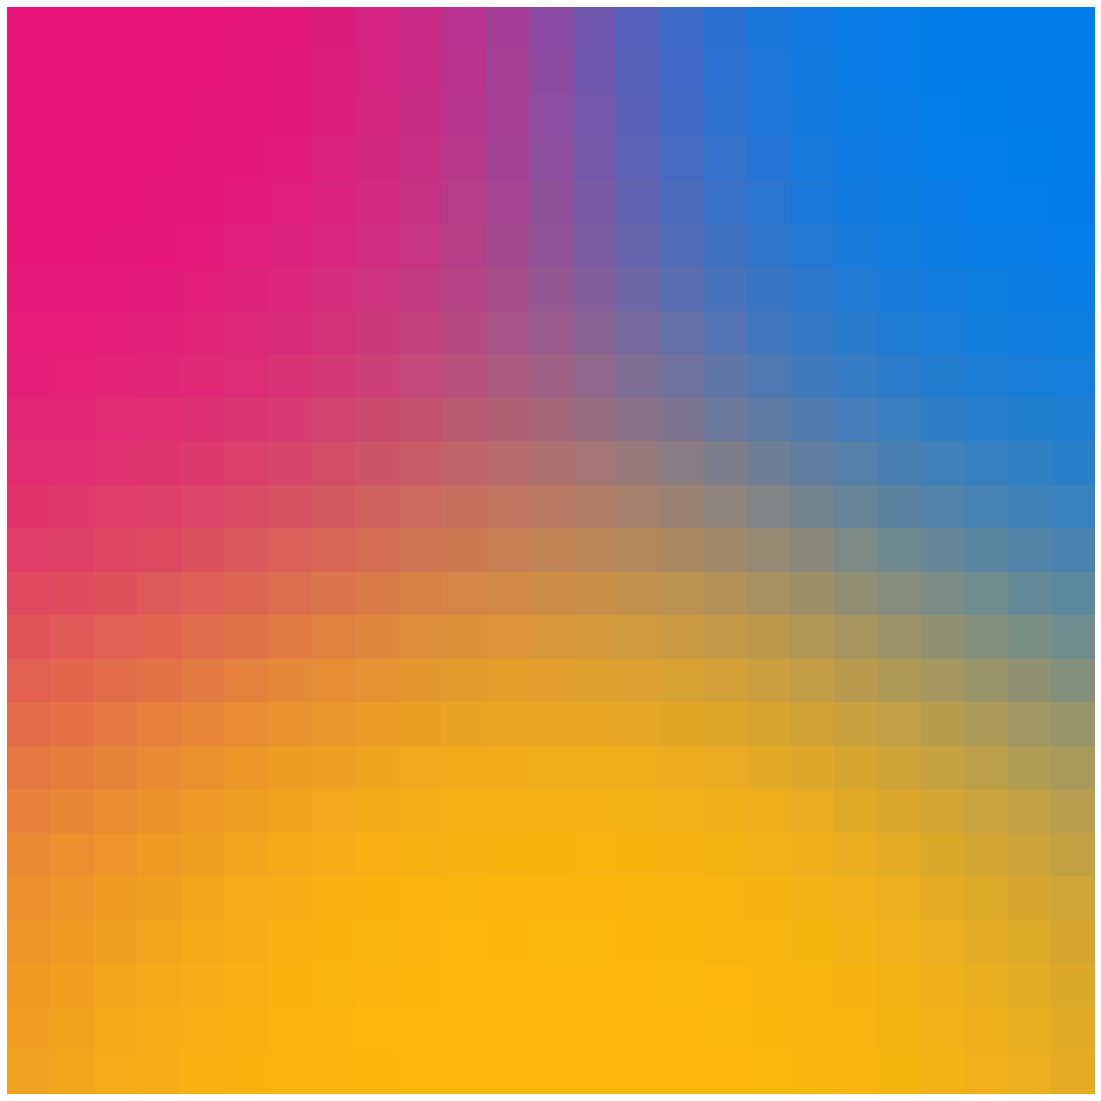

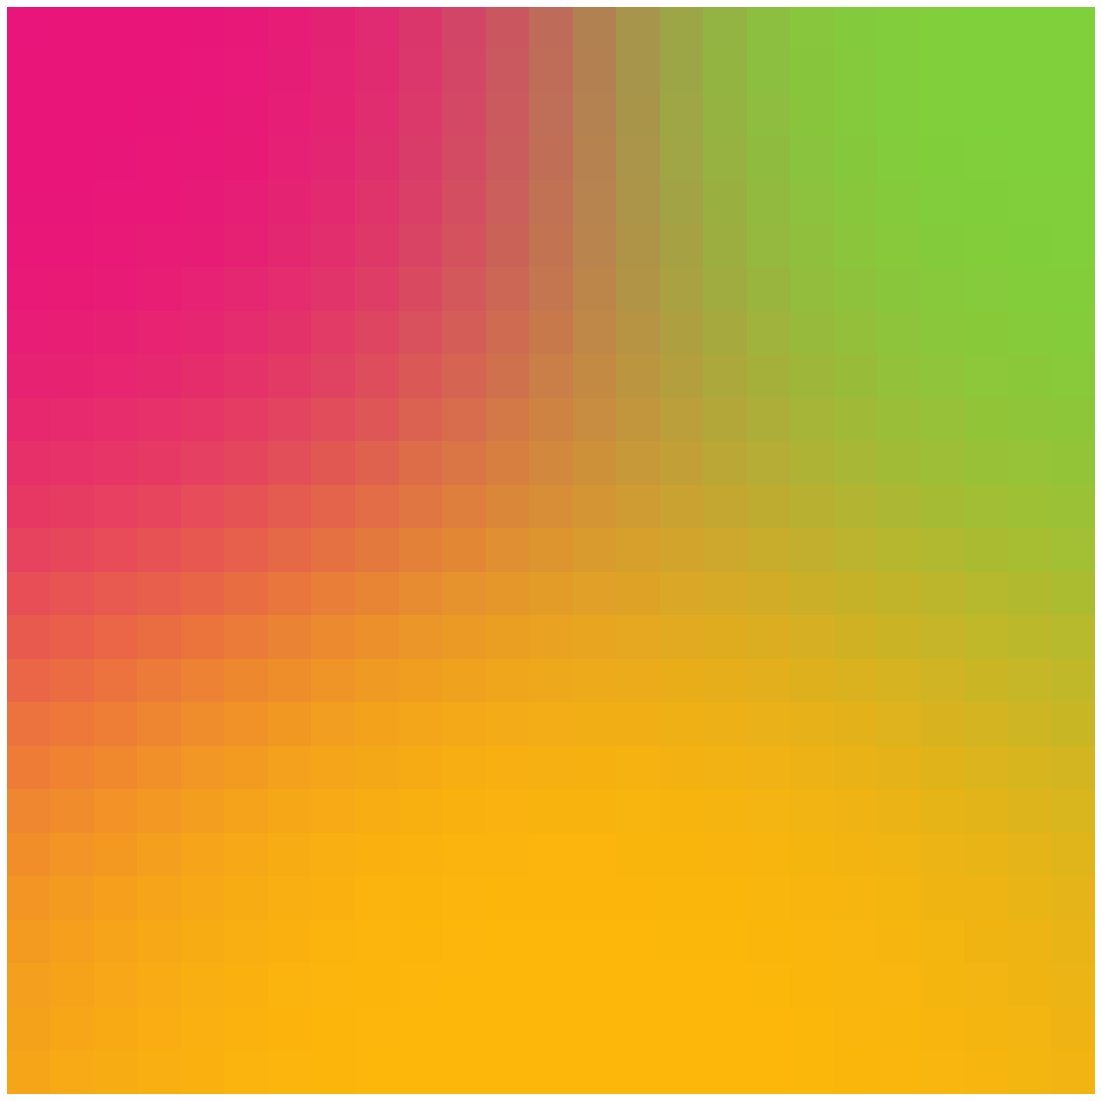

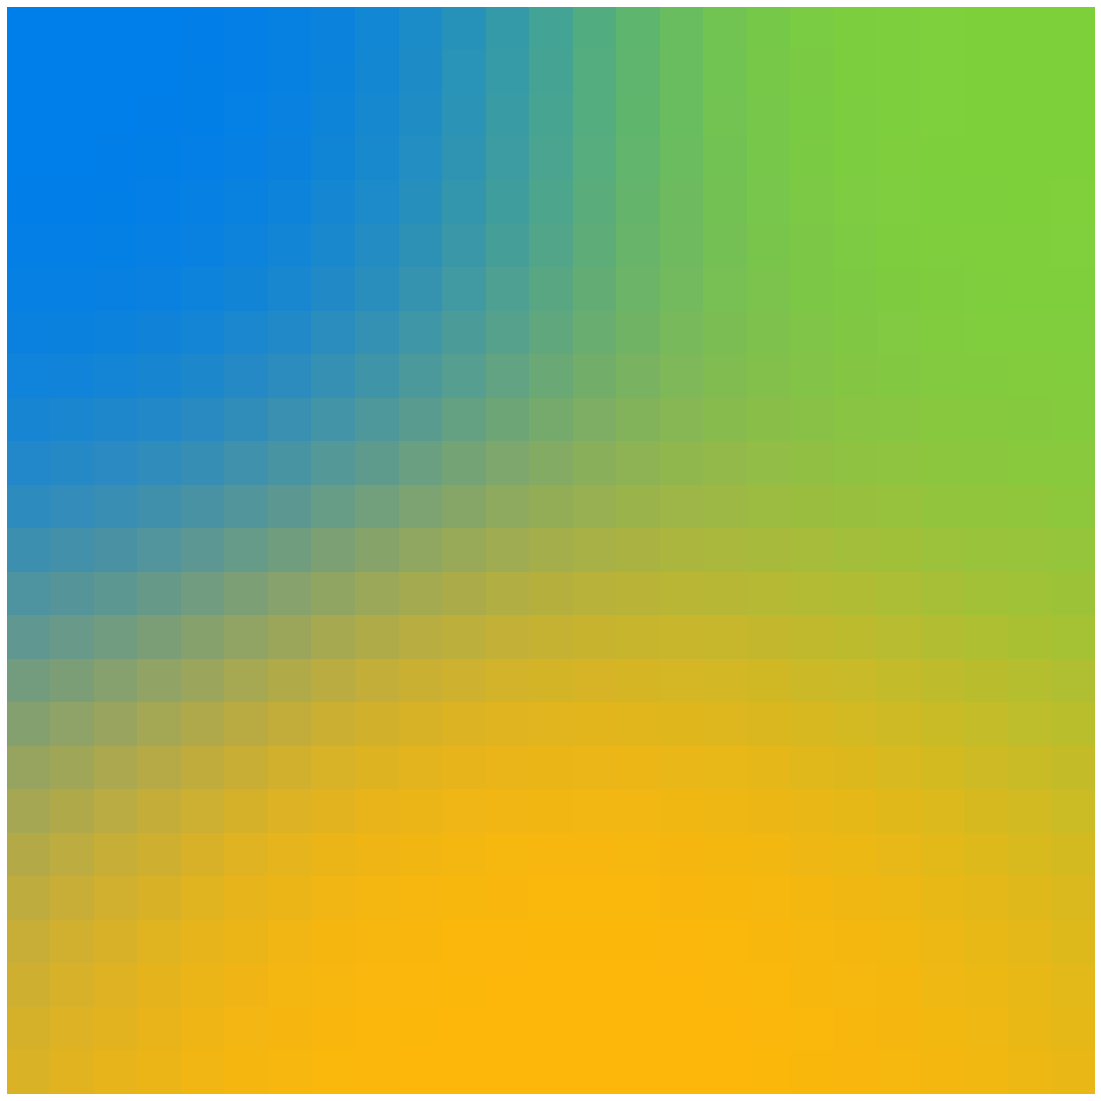

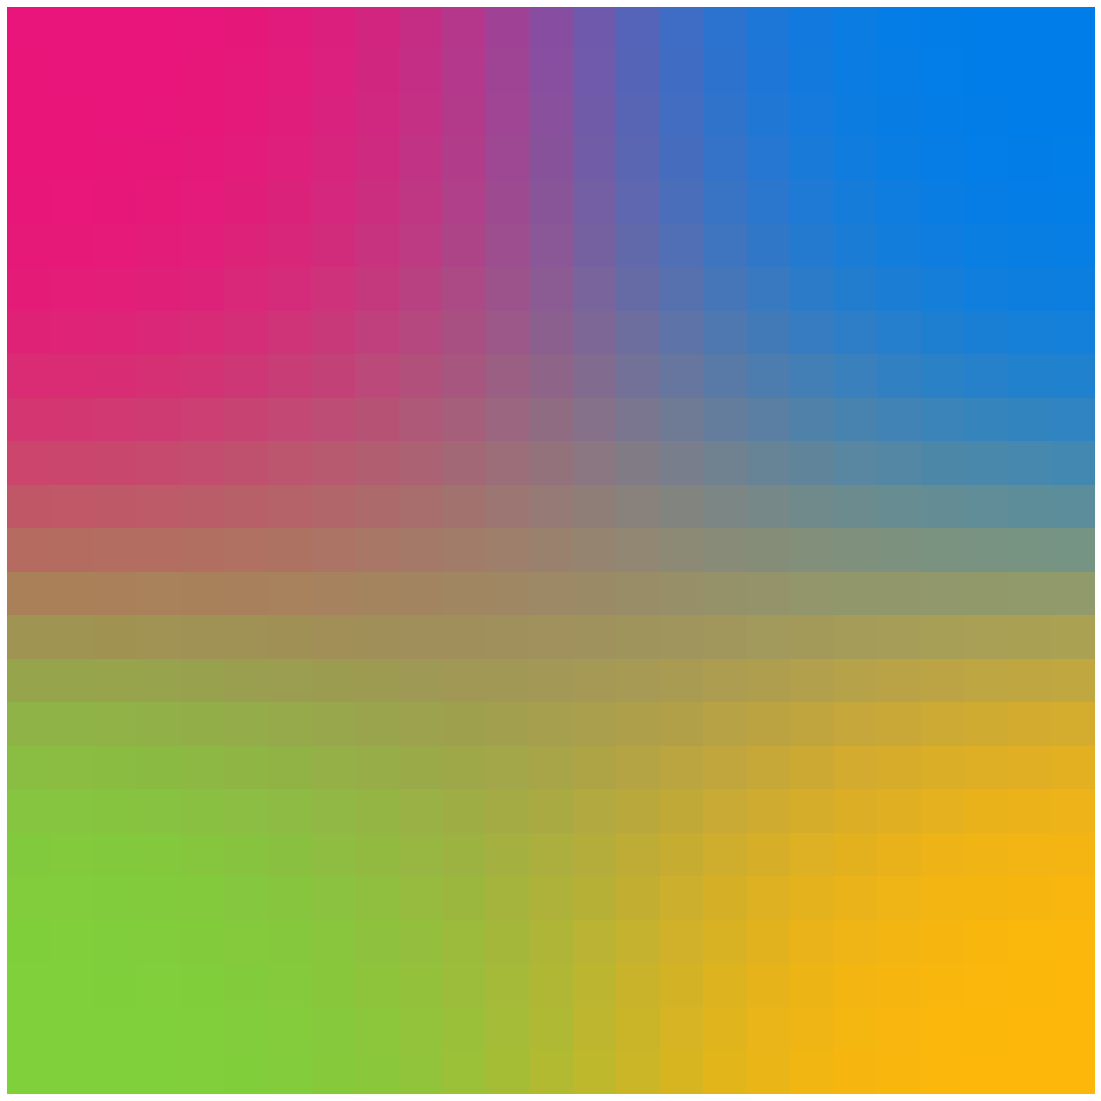

In [80]:
blue = "#007EEA"
orange = "#FEB80A"
green = "#7FD13B"
pink = "#EA157A"

def make_plot(colors, is_triangle=False, n=25, p=3):
    corners = [(0,0), (0,n), (n, n/2)] if is_triangle else [(0,0),(0,n),(n,0),(n,n)]
    def make_color(xy, corners=corners, colors=colors, p=p):
        if xy in corners:
            return next(col for corn, col in zip(corners, colors) if xy==corn)

            pass

        weights = [(((xy[0]-x)**2 + (xy[1]-y)**2)**0.5) ** (-p) for (x,y) in corners]
        denom = sum(weights)


        rs,gs,bs = zip(*colors)
        r = sum(ri * wi / denom for ri, wi in zip(rs, weights))
        g = sum(gi * wi / denom for gi, wi in zip(gs, weights))
        b = sum(bi * wi / denom for bi, wi in zip(bs, weights))
        return [r,g,b]
    
    cmixed = np.zeros((n,n,3))
    for i,j in combinations(range(n), 2):
        cmixed[i,j] = make_color((i,j))
        cmixed[j,i] = make_color((j,i))
    for i in range(n):
        cmixed[i,i] = make_color((i,i))
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.imshow(cmixed)
    plt.axis('off')
    
    return fig

colors = [to_rgb(pink), to_rgb(blue), to_rgb(green), to_rgb(orange)]


output_dir = "plots/fig_4_5_supp_fig_5_6/"
if not os.path.exists(output_dir): os.makedirs(output_dir)

for idx, three_color in enumerate(combinations(colors, 3)):
    f = make_plot(three_color, is_triangle=True)
    f.savefig(os.path.join(output_dir, "triangle_{0}.svg".format(idx)), bbox_inches='tight', transparent=True)
    plt.show()
    
f = make_plot(colors)
f.savefig(os.path.join(output_dir, "four_color.svg"), bbox_inches='tight', transparent=True)